### MRMR-More

More experiments with the MRMR codebase.

In [1]:
import sys
sys.path.append("../..")
from exp_run_config import Config
Config.PROJECTNAME = "WaterBerryFarms"

import pathlib
import yaml
import tqdm
from wbf_simulate import run_nrobot1day
from mrmr_graphics import load_back_results, show_robot_with_plan, show_robot_trajectories_and_detections, count_detections, show_agentwise_detections, show_comparative_detections

In [2]:
# Run an experiment with a different budget
experiment_path = pathlib.Path(Config()["experiment_external"]).expanduser()
experiment_path.mkdir(exist_ok=True)
experiment_data = pathlib.Path(Config()["data_external"]).expanduser()
experiment_data.mkdir(exist_ok=True)

Config().set_experiment_path(experiment_path)
Config().set_experiment_data(experiment_data)
# FIXME this is dangerous, because if it has the original paths, it overwrites the experiments, this needs to be fixed
Config().copy_experiment("mrmr")
Config().copy_experiment("environment")
Config().copy_experiment("policy")
Config().copy_experiment("estimator")
Config().copy_experiment("score")

exp_dest = Config().get_experiment("mrmr", "mrmr_more")

ROBOT_COLORS = ["#E69F00", "#56B4E9", "#009E73", "#00FFFF", "#FF00FF",  "#FFFF00"]
SHORT_NAME_LOOKUP = {}

***ExpRun**: Loading pointer config file:
	/Users/lboloni/.config/WaterBerryFarms/mainsettings.yaml
***ExpRun**: Loading machine-specific config file:
	/Users/lboloni/Google Drive/My Drive/LotziStudy/Code/PackageTracking/WaterBerryFarms/settings/WBF-config-szenes.yaml
***ExpRun**: Experiment config path changed to /Users/lboloni/Documents/Develop/Data/WBF-exp-external
***ExpRun**: Experiment data path changed to /Users/lboloni/Documents/Develop/Data/WBF-data-external
***ExpRun**: Experiment mrmr copied to /Users/lboloni/Documents/Develop/Data/WBF-exp-external/mrmr
***ExpRun**: Experiment environment copied to /Users/lboloni/Documents/Develop/Data/WBF-exp-external/environment
***ExpRun**: Experiment policy copied to /Users/lboloni/Documents/Develop/Data/WBF-exp-external/policy
***ExpRun**: Experiment estimator copied to /Users/lboloni/Documents/Develop/Data/WBF-exp-external/estimator
***ExpRun**: Experiment score copied to /Users/lboloni/Documents/Develop/Data/WBF-exp-external/score
***

In [3]:
def generate_rw(experiment="mrmr", n_robots = 1, budget = 1000, environment = "mrmr-custom-notclustered"):
    """Generate experiment with n robots following random waypoint, and save it to the experiment path"""
    runname = f"gen-rw-n_{n_robots}-b_{budget}-e_{environment}"
    val = {}    
    val["name"] = "n random waypoint"

    val["exp_environment"] = "environment"
    val["run_environment"] = environment

    val["exp_estimator"] = "estimator"
    val["run_estimator"] = "adaptive-disk"

    val["exp_score"] = "score"
    val["run_score"] = "weighted_asymmetric"

    val["timesteps-per-day"] = budget
    val["time-start-environment"] = 19

    robots = []
    val["robots"] = robots

    for robot in range(n_robots):
        v = {}
        robots.append(v)
        v["name"] = f"robot-{robot+1}"
        v["exp-policy"] = "policy"
        v["run-policy"] = "random-waypoint"
        vextra = {}
        v["exp-policy-extra-parameters"] = vextra
        vextra["seed"] = robot
        vextra["policy-name"] = f"rwp-{robot}"
        vextra["budget"] = budget
    # save the generated exprun spec
    path = pathlib.Path(Config().get_experiment_path(), experiment, runname + ".yaml")
    with open(path, "w") as f:
        yaml.dump(val, f)
    return runname

In [4]:
def generate_lawnmowers(experiment = "mrmr", n_robots = 1, budget = 1000, environment = "mrmr-custom-notclustered"):
    """Generate experiment with n robots following lawnmower, with the area being divided into n areas"""
    runname = f"gen-lawn-n_{n_robots}-b_{budget}-e_{environment}"
    val = {}    
    val["name"] = "n random waypoint"

    val["exp_environment"] = "environment"
    val["run_environment"] = environment

    val["exp_estimator"] = "estimator"
    val["run_estimator"] = "adaptive-disk"

    val["exp_score"] = "score"
    val["run_score"] = "weighted_asymmetric"

    val["timesteps-per-day"] = budget
    val["time-start-environment"] = 19

    robots = []
    val["robots"] = robots

    for robot in range(n_robots):
        v = {}
        robots.append(v)
        v["name"] = f"robot-{robot+1}"
        v["exp-policy"] = "policy"
        v["run-policy"] = "fixed-budget-lawnmower"
        vextra = {}
        v["exp-policy-extra-parameters"] = vextra
        area = [0,0,0,0]
        border = 5
        width = (100 - 2 * border) / n_robots
        area[0] = int(border)
        area[1] = int(border + robot * width)
        area[2] = 100 - border
        area[3] = int(border + (robot+1) * width)
        vextra["area"] = str(area)
        vextra["policy-name"] = f"mrse-{robot}"
        vextra["budget"] = budget

    # save the generated path 
    path = pathlib.Path(Config().get_experiment_path(), experiment, runname + ".yaml")
    with open(path, "w") as f:
        yaml.dump(val, f)
    return runname

In [5]:
def generate_mrmr(experiment="mrmr", n_robots = 1, budget = 1000, environment = "mrmr-custom-notclustered"):
    """Generate experiment with n robots following lawnmower, with the area being divided into n areas"""
    runname = f"gen-mrmr-n_{n_robots}-b_{budget}-e_{environment}"
    val = {}    
    val["name"] = "n random waypoint"

    val["exp_environment"] = "environment"
    val["run_environment"] = environment

    val["exp_estimator"] = "estimator"
    val["run_estimator"] = "adaptive-disk"

    val["exp_score"] = "score"
    val["run_score"] = "weighted_asymmetric"

    val["timesteps-per-day"] = budget
    val["time-start-environment"] = 19

    robots = []
    val["robots"] = robots

    # generate the first robot, the pioneer
    v = {}
    robots.append(v)
    v["name"] = f"pio"
    v["exp-policy"] = "policy"
    v["run-policy"] = "generic"    
    vextra = {}
    v["exp-policy-extra-parameters"] = vextra
    vextra["policy-name"] = f"mrmr-pioneer"
    vextra["policy-code"] = "MRMR_Pioneer"
    vextra["seed"] = 1
    vextra["budget"] = budget

    # generate the other robots, the contractors
    for robot in range(n_robots-1):
        v = {}
        robots.append(v)
        v["name"] = f"con-{robot}"
        v["exp-policy"] = "policy"
        v["run-policy"] = "generic"
        vextra = {}
        v["exp-policy-extra-parameters"] = vextra
        vextra["seed"] = robot + 1
        vextra["policy-name"] = f"mrmr-contractor-{robot}"
        vextra["policy-code"] = "MRMR_Contractor"
        vextra["budget"] = budget

    # save the generated path 
    path = pathlib.Path(Config().get_experiment_path(), experiment, runname + ".yaml")
    with open(path, "w") as f:
        yaml.dump(val, f)
    return runname

### Generate a range of experiments

In [6]:
# run = generate_rw(n_robots=3, budget=1000)
# run = generate_lawnmowers(n_robots=3, budget=1000)
runs = []
# runs for comparison different robots, budget 1000
runs_b1000_clustered = []
runs_n3_clustered = []
runs_b1000_unclustered = []
runs_n3_unclustered = []

# FIXME: generate some other lists as well
experiment = "mrmr"

for n_robots in range(1, 5):
    #for budget in [500, 1000, 1500, 2000]:
    for budget in [500, 1000, 1500]:
        for environment in ["mrmr-custom-notclustered", "mrmr-custom-clustered"]:
            # lawnmowers
            runs2 = []
            run = generate_lawnmowers(experiment, n_robots=n_robots, budget=budget, environment = environment)
            runs2.append(run)
            # random waypoint
            run = generate_rw(experiment, n_robots=n_robots, budget=budget, environment = environment)
            runs2.append(run)
            # mrmr
            run = generate_mrmr(experiment, n_robots=n_robots, budget=budget, environment = environment)
            runs2.append(run)
            # 
            runs.extend(runs2)
            if budget == 1000 and environment == "mrmr-custom-clustered":
                runs_b1000_clustered.extend(runs2)
            if budget == 1000 and environment == "mrmr-custom-notclustered":
                runs_b1000_unclustered.extend(runs2)
            if n_robots == 3 and environment == "mrmr-custom-clustered":
                runs_n3_clustered.extend(runs2)
            if n_robots == 3 and environment == "mrmr-custom-notclustered":
                runs_n3_unclustered.extend(runs2)



### Run the experiments
Run all the experiments

In [7]:
for run in tqdm.tqdm(runs):
    exp = Config().get_experiment("mrmr", run)
    run_nrobot1day(exp)

  0%|          | 0/72 [00:00<?, ?it/s]

***ExpRun**: Configuration for exp/run: mrmr/gen-lawn-n_1-b_500-e_mrmr-custom-notclustered successfully loaded
Results file already exists:
/Users/lboloni/Documents/Develop/Data/WBF-data-external/mrmr/gen-lawn-n_1-b_500-e_mrmr-custom-notclustered/results.pickle
***ExpRun**: Configuration for exp/run: mrmr/gen-rw-n_1-b_500-e_mrmr-custom-notclustered successfully loaded
***ExpRun**: Experiment default config /Users/lboloni/Documents/Develop/Data/WBF-exp-external/environment/_defaults_environment.yaml was empty, ok.
***ExpRun**: Configuration for exp/run: environment/mrmr-custom-notclustered successfully loaded
***ExpRun**: Experiment default config /Users/lboloni/Documents/Develop/Data/WBF-exp-external/estimator/_defaults_estimator.yaml was empty, ok.
***ExpRun**: Configuration for exp/run: estimator/adaptive-disk successfully loaded
***ExpRun**: Experiment default config /Users/lboloni/Documents/Develop/Data/WBF-exp-external/score/_defaults_score.yaml was empty, ok.
***ExpRun**: Configu

INFO:root:create_type_map shape=(10201,)
INFO:root:Infection matrix: [0.         0.25       0.4375     0.578125   0.68359375 0.76269531
 0.82202148 0.86651611 0.89988708 0.92491531 0.94368649 0.95776486
 0.96832365 0.97624274 0.98218205 0.98663654 0.9899774  0.99248305
 0.99436229 0.99577172 0.99682879 0.99762159 0.99821619 0.99866214
 0.99899661]
INFO:root:Infection matrix: [0.         0.15       0.2775     0.385875   0.47799375 0.55629469
 0.62285048 0.67942291 0.72750947 0.76838305 0.8031256  0.83265676
 0.85775824 0.87909451 0.89723033 0.91264578 0.92574891 0.93688658
 0.94635359 0.95440055 0.96124047 0.9670544  0.97199624 0.9761968
 0.97976728]
INFO:root:Environment.proceed - calling the inner_proceed
INFO:root:Environment.proceed - calling the inner_proceed
INFO:root:PrecalculatedEnvironment at timestamp 1
INFO:root:PrecalculatedEnvironment: file /Users/lboloni/Documents/Develop/Data/WBF-data-external/environment/mrmr-custom-notclustered/precalc_tylcv/env_value_00001.gz already e

budget
policy-name
seed
loading from /Users/lboloni/Documents/Develop/Data/WBF-exp-external/environment/mrmr-notclustered-100.png
[[[255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]
  ...
  [255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]]

 [[255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]
  ...
  [255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]]

 [[255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]
  ...
  [255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]]

 ...

 [[255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]
  ...
  [255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]]

 [[255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]
  ...
  [255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]]

 [[255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]
  ...
  [255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]]]


  3%|▎         | 2/72 [00:00<00:09,  7.15it/s]

Saving results to: /Users/lboloni/Documents/Develop/Data/WBF-data-external/mrmr/gen-rw-n_1-b_500-e_mrmr-custom-notclustered/results.pickle
***ExpRun**: Configuration for exp/run: mrmr/gen-mrmr-n_1-b_500-e_mrmr-custom-notclustered successfully loaded
***ExpRun**: Experiment default config /Users/lboloni/Documents/Develop/Data/WBF-exp-external/environment/_defaults_environment.yaml was empty, ok.
***ExpRun**: Configuration for exp/run: environment/mrmr-custom-notclustered successfully loaded
***ExpRun**: Experiment default config /Users/lboloni/Documents/Develop/Data/WBF-exp-external/estimator/_defaults_estimator.yaml was empty, ok.
***ExpRun**: Configuration for exp/run: estimator/adaptive-disk successfully loaded
***ExpRun**: Experiment default config /Users/lboloni/Documents/Develop/Data/WBF-exp-external/score/_defaults_score.yaml was empty, ok.
***ExpRun**: Configuration for exp/run: score/weighted_asymmetric successfully loaded
***ExpRun**: Experiment default config /Users/lboloni/D

INFO:root:create_type_map shape=(10201,)
INFO:root:Infection matrix: [0.         0.25       0.4375     0.578125   0.68359375 0.76269531
 0.82202148 0.86651611 0.89988708 0.92491531 0.94368649 0.95776486
 0.96832365 0.97624274 0.98218205 0.98663654 0.9899774  0.99248305
 0.99436229 0.99577172 0.99682879 0.99762159 0.99821619 0.99866214
 0.99899661]
INFO:root:Infection matrix: [0.         0.15       0.2775     0.385875   0.47799375 0.55629469
 0.62285048 0.67942291 0.72750947 0.76838305 0.8031256  0.83265676
 0.85775824 0.87909451 0.89723033 0.91264578 0.92574891 0.93688658
 0.94635359 0.95440055 0.96124047 0.9670544  0.97199624 0.9761968
 0.97976728]
INFO:root:Environment.proceed - calling the inner_proceed
INFO:root:Environment.proceed - calling the inner_proceed
INFO:root:PrecalculatedEnvironment at timestamp 1
INFO:root:PrecalculatedEnvironment: file /Users/lboloni/Documents/Develop/Data/WBF-data-external/environment/mrmr-custom-notclustered/precalc_tylcv/env_value_00001.gz already e

budget
policy-code
policy-name
seed
loading from /Users/lboloni/Documents/Develop/Data/WBF-exp-external/environment/mrmr-notclustered-100.png
[[[255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]
  ...
  [255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]]

 [[255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]
  ...
  [255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]]

 [[255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]
  ...
  [255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]]

 ...

 [[255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]
  ...
  [255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]]

 [[255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]
  ...
  [255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]]

 [[255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]
  ...
  [255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]]]


  4%|▍         | 3/72 [00:00<00:13,  5.13it/s]

Saving results to: /Users/lboloni/Documents/Develop/Data/WBF-data-external/mrmr/gen-mrmr-n_1-b_500-e_mrmr-custom-notclustered/results.pickle
***ExpRun**: Configuration for exp/run: mrmr/gen-lawn-n_1-b_500-e_mrmr-custom-clustered successfully loaded
Results file already exists:
/Users/lboloni/Documents/Develop/Data/WBF-data-external/mrmr/gen-lawn-n_1-b_500-e_mrmr-custom-clustered/results.pickle
***ExpRun**: Configuration for exp/run: mrmr/gen-rw-n_1-b_500-e_mrmr-custom-clustered successfully loaded
***ExpRun**: Experiment default config /Users/lboloni/Documents/Develop/Data/WBF-exp-external/environment/_defaults_environment.yaml was empty, ok.
***ExpRun**: Configuration for exp/run: environment/mrmr-custom-clustered successfully loaded
***ExpRun**: Experiment default config /Users/lboloni/Documents/Develop/Data/WBF-exp-external/estimator/_defaults_estimator.yaml was empty, ok.
***ExpRun**: Configuration for exp/run: estimator/adaptive-disk successfully loaded
***ExpRun**: Experiment def

INFO:root:create_type_map shape=(10201,)
INFO:root:Infection matrix: [0.         0.25       0.4375     0.578125   0.68359375 0.76269531
 0.82202148 0.86651611 0.89988708 0.92491531 0.94368649 0.95776486
 0.96832365 0.97624274 0.98218205 0.98663654 0.9899774  0.99248305
 0.99436229 0.99577172 0.99682879 0.99762159 0.99821619 0.99866214
 0.99899661]
INFO:root:Infection matrix: [0.         0.15       0.2775     0.385875   0.47799375 0.55629469
 0.62285048 0.67942291 0.72750947 0.76838305 0.8031256  0.83265676
 0.85775824 0.87909451 0.89723033 0.91264578 0.92574891 0.93688658
 0.94635359 0.95440055 0.96124047 0.9670544  0.97199624 0.9761968
 0.97976728]
INFO:root:Environment.proceed - calling the inner_proceed
INFO:root:Environment.proceed - calling the inner_proceed
INFO:root:PrecalculatedEnvironment at timestamp 1
INFO:root:PrecalculatedEnvironment: file /Users/lboloni/Documents/Develop/Data/WBF-data-external/environment/mrmr-custom-clustered/precalc_tylcv/env_value_00001.gz already exis

budget
policy-name
seed
loading from /Users/lboloni/Documents/Develop/Data/WBF-exp-external/environment/mrmr-clustered-100.png
[[[255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]
  ...
  [255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]]

 [[255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]
  ...
  [255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]]

 [[255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]
  ...
  [255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]]

 ...

 [[255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]
  ...
  [255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]]

 [[255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]
  ...
  [255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]]

 [[255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]
  ...
  [255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]]]


  7%|▋         | 5/72 [00:00<00:10,  6.12it/s]

Saving results to: /Users/lboloni/Documents/Develop/Data/WBF-data-external/mrmr/gen-rw-n_1-b_500-e_mrmr-custom-clustered/results.pickle
***ExpRun**: Configuration for exp/run: mrmr/gen-mrmr-n_1-b_500-e_mrmr-custom-clustered successfully loaded
***ExpRun**: Experiment default config /Users/lboloni/Documents/Develop/Data/WBF-exp-external/environment/_defaults_environment.yaml was empty, ok.
***ExpRun**: Configuration for exp/run: environment/mrmr-custom-clustered successfully loaded
***ExpRun**: Experiment default config /Users/lboloni/Documents/Develop/Data/WBF-exp-external/estimator/_defaults_estimator.yaml was empty, ok.
***ExpRun**: Configuration for exp/run: estimator/adaptive-disk successfully loaded
***ExpRun**: Experiment default config /Users/lboloni/Documents/Develop/Data/WBF-exp-external/score/_defaults_score.yaml was empty, ok.
***ExpRun**: Configuration for exp/run: score/weighted_asymmetric successfully loaded
***ExpRun**: Experiment default config /Users/lboloni/Documents/

INFO:root:create_type_map shape=(10201,)
INFO:root:Infection matrix: [0.         0.25       0.4375     0.578125   0.68359375 0.76269531
 0.82202148 0.86651611 0.89988708 0.92491531 0.94368649 0.95776486
 0.96832365 0.97624274 0.98218205 0.98663654 0.9899774  0.99248305
 0.99436229 0.99577172 0.99682879 0.99762159 0.99821619 0.99866214
 0.99899661]
INFO:root:Infection matrix: [0.         0.15       0.2775     0.385875   0.47799375 0.55629469
 0.62285048 0.67942291 0.72750947 0.76838305 0.8031256  0.83265676
 0.85775824 0.87909451 0.89723033 0.91264578 0.92574891 0.93688658
 0.94635359 0.95440055 0.96124047 0.9670544  0.97199624 0.9761968
 0.97976728]
INFO:root:Environment.proceed - calling the inner_proceed
INFO:root:Environment.proceed - calling the inner_proceed
INFO:root:PrecalculatedEnvironment at timestamp 1
INFO:root:PrecalculatedEnvironment: file /Users/lboloni/Documents/Develop/Data/WBF-data-external/environment/mrmr-custom-clustered/precalc_tylcv/env_value_00001.gz already exis

budget
policy-code
policy-name
seed
loading from /Users/lboloni/Documents/Develop/Data/WBF-exp-external/environment/mrmr-clustered-100.png
[[[255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]
  ...
  [255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]]

 [[255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]
  ...
  [255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]]

 [[255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]
  ...
  [255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]]

 ...

 [[255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]
  ...
  [255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]]

 [[255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]
  ...
  [255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]]

 [[255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]
  ...
  [255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]]]


  8%|▊         | 6/72 [00:01<00:12,  5.12it/s]

Saving results to: /Users/lboloni/Documents/Develop/Data/WBF-data-external/mrmr/gen-mrmr-n_1-b_500-e_mrmr-custom-clustered/results.pickle
***ExpRun**: Configuration for exp/run: mrmr/gen-lawn-n_1-b_1000-e_mrmr-custom-notclustered successfully loaded
Results file already exists:
/Users/lboloni/Documents/Develop/Data/WBF-data-external/mrmr/gen-lawn-n_1-b_1000-e_mrmr-custom-notclustered/results.pickle
***ExpRun**: Configuration for exp/run: mrmr/gen-rw-n_1-b_1000-e_mrmr-custom-notclustered successfully loaded
***ExpRun**: Experiment default config /Users/lboloni/Documents/Develop/Data/WBF-exp-external/environment/_defaults_environment.yaml was empty, ok.
***ExpRun**: Configuration for exp/run: environment/mrmr-custom-notclustered successfully loaded
***ExpRun**: Experiment default config /Users/lboloni/Documents/Develop/Data/WBF-exp-external/estimator/_defaults_estimator.yaml was empty, ok.
***ExpRun**: Configuration for exp/run: estimator/adaptive-disk successfully loaded
***ExpRun**: Ex

INFO:root:create_type_map shape=(10201,)
INFO:root:Infection matrix: [0.         0.25       0.4375     0.578125   0.68359375 0.76269531
 0.82202148 0.86651611 0.89988708 0.92491531 0.94368649 0.95776486
 0.96832365 0.97624274 0.98218205 0.98663654 0.9899774  0.99248305
 0.99436229 0.99577172 0.99682879 0.99762159 0.99821619 0.99866214
 0.99899661]
INFO:root:Infection matrix: [0.         0.15       0.2775     0.385875   0.47799375 0.55629469
 0.62285048 0.67942291 0.72750947 0.76838305 0.8031256  0.83265676
 0.85775824 0.87909451 0.89723033 0.91264578 0.92574891 0.93688658
 0.94635359 0.95440055 0.96124047 0.9670544  0.97199624 0.9761968
 0.97976728]
INFO:root:Environment.proceed - calling the inner_proceed
INFO:root:Environment.proceed - calling the inner_proceed
INFO:root:PrecalculatedEnvironment at timestamp 1
INFO:root:PrecalculatedEnvironment: file /Users/lboloni/Documents/Develop/Data/WBF-data-external/environment/mrmr-custom-notclustered/precalc_tylcv/env_value_00001.gz already e

budget
policy-name
seed
loading from /Users/lboloni/Documents/Develop/Data/WBF-exp-external/environment/mrmr-notclustered-100.png
[[[255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]
  ...
  [255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]]

 [[255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]
  ...
  [255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]]

 [[255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]
  ...
  [255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]]

 ...

 [[255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]
  ...
  [255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]]

 [[255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]
  ...
  [255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]]

 [[255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]
  ...
  [255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]]]


 11%|█         | 8/72 [00:02<00:19,  3.21it/s]

Saving results to: /Users/lboloni/Documents/Develop/Data/WBF-data-external/mrmr/gen-rw-n_1-b_1000-e_mrmr-custom-notclustered/results.pickle
***ExpRun**: Configuration for exp/run: mrmr/gen-mrmr-n_1-b_1000-e_mrmr-custom-notclustered successfully loaded
***ExpRun**: Experiment default config /Users/lboloni/Documents/Develop/Data/WBF-exp-external/environment/_defaults_environment.yaml was empty, ok.
***ExpRun**: Configuration for exp/run: environment/mrmr-custom-notclustered successfully loaded
***ExpRun**: Experiment default config /Users/lboloni/Documents/Develop/Data/WBF-exp-external/estimator/_defaults_estimator.yaml was empty, ok.
***ExpRun**: Configuration for exp/run: estimator/adaptive-disk successfully loaded
***ExpRun**: Experiment default config /Users/lboloni/Documents/Develop/Data/WBF-exp-external/score/_defaults_score.yaml was empty, ok.
***ExpRun**: Configuration for exp/run: score/weighted_asymmetric successfully loaded
***ExpRun**: Experiment default config /Users/lboloni

INFO:root:create_type_map shape=(10201,)
INFO:root:Infection matrix: [0.         0.25       0.4375     0.578125   0.68359375 0.76269531
 0.82202148 0.86651611 0.89988708 0.92491531 0.94368649 0.95776486
 0.96832365 0.97624274 0.98218205 0.98663654 0.9899774  0.99248305
 0.99436229 0.99577172 0.99682879 0.99762159 0.99821619 0.99866214
 0.99899661]
INFO:root:Infection matrix: [0.         0.15       0.2775     0.385875   0.47799375 0.55629469
 0.62285048 0.67942291 0.72750947 0.76838305 0.8031256  0.83265676
 0.85775824 0.87909451 0.89723033 0.91264578 0.92574891 0.93688658
 0.94635359 0.95440055 0.96124047 0.9670544  0.97199624 0.9761968
 0.97976728]
INFO:root:Environment.proceed - calling the inner_proceed
INFO:root:Environment.proceed - calling the inner_proceed
INFO:root:PrecalculatedEnvironment at timestamp 1
INFO:root:PrecalculatedEnvironment: file /Users/lboloni/Documents/Develop/Data/WBF-data-external/environment/mrmr-custom-notclustered/precalc_tylcv/env_value_00001.gz already e

budget
policy-code
policy-name
seed
loading from /Users/lboloni/Documents/Develop/Data/WBF-exp-external/environment/mrmr-notclustered-100.png
[[[255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]
  ...
  [255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]]

 [[255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]
  ...
  [255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]]

 [[255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]
  ...
  [255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]]

 ...

 [[255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]
  ...
  [255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]]

 [[255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]
  ...
  [255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]]

 [[255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]
  ...
  [255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]]]


 12%|█▎        | 9/72 [00:02<00:28,  2.19it/s]

Saving results to: /Users/lboloni/Documents/Develop/Data/WBF-data-external/mrmr/gen-mrmr-n_1-b_1000-e_mrmr-custom-notclustered/results.pickle
***ExpRun**: Configuration for exp/run: mrmr/gen-lawn-n_1-b_1000-e_mrmr-custom-clustered successfully loaded
Results file already exists:
/Users/lboloni/Documents/Develop/Data/WBF-data-external/mrmr/gen-lawn-n_1-b_1000-e_mrmr-custom-clustered/results.pickle
***ExpRun**: Configuration for exp/run: mrmr/gen-rw-n_1-b_1000-e_mrmr-custom-clustered successfully loaded
***ExpRun**: Experiment default config /Users/lboloni/Documents/Develop/Data/WBF-exp-external/environment/_defaults_environment.yaml was empty, ok.
***ExpRun**: Configuration for exp/run: environment/mrmr-custom-clustered successfully loaded
***ExpRun**: Experiment default config /Users/lboloni/Documents/Develop/Data/WBF-exp-external/estimator/_defaults_estimator.yaml was empty, ok.
***ExpRun**: Configuration for exp/run: estimator/adaptive-disk successfully loaded
***ExpRun**: Experiment

INFO:root:create_type_map shape=(10201,)
INFO:root:Infection matrix: [0.         0.25       0.4375     0.578125   0.68359375 0.76269531
 0.82202148 0.86651611 0.89988708 0.92491531 0.94368649 0.95776486
 0.96832365 0.97624274 0.98218205 0.98663654 0.9899774  0.99248305
 0.99436229 0.99577172 0.99682879 0.99762159 0.99821619 0.99866214
 0.99899661]
INFO:root:Infection matrix: [0.         0.15       0.2775     0.385875   0.47799375 0.55629469
 0.62285048 0.67942291 0.72750947 0.76838305 0.8031256  0.83265676
 0.85775824 0.87909451 0.89723033 0.91264578 0.92574891 0.93688658
 0.94635359 0.95440055 0.96124047 0.9670544  0.97199624 0.9761968
 0.97976728]
INFO:root:Environment.proceed - calling the inner_proceed
INFO:root:Environment.proceed - calling the inner_proceed
INFO:root:PrecalculatedEnvironment at timestamp 1
INFO:root:PrecalculatedEnvironment: file /Users/lboloni/Documents/Develop/Data/WBF-data-external/environment/mrmr-custom-clustered/precalc_tylcv/env_value_00001.gz already exis

budget
policy-name
seed
loading from /Users/lboloni/Documents/Develop/Data/WBF-exp-external/environment/mrmr-clustered-100.png
[[[255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]
  ...
  [255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]]

 [[255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]
  ...
  [255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]]

 [[255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]
  ...
  [255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]]

 ...

 [[255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]
  ...
  [255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]]

 [[255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]
  ...
  [255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]]

 [[255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]
  ...
  [255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]]]


 15%|█▌        | 11/72 [00:03<00:28,  2.12it/s]

Saving results to: /Users/lboloni/Documents/Develop/Data/WBF-data-external/mrmr/gen-rw-n_1-b_1000-e_mrmr-custom-clustered/results.pickle
***ExpRun**: Configuration for exp/run: mrmr/gen-mrmr-n_1-b_1000-e_mrmr-custom-clustered successfully loaded
***ExpRun**: Experiment default config /Users/lboloni/Documents/Develop/Data/WBF-exp-external/environment/_defaults_environment.yaml was empty, ok.
***ExpRun**: Configuration for exp/run: environment/mrmr-custom-clustered successfully loaded
***ExpRun**: Experiment default config /Users/lboloni/Documents/Develop/Data/WBF-exp-external/estimator/_defaults_estimator.yaml was empty, ok.
***ExpRun**: Configuration for exp/run: estimator/adaptive-disk successfully loaded
***ExpRun**: Experiment default config /Users/lboloni/Documents/Develop/Data/WBF-exp-external/score/_defaults_score.yaml was empty, ok.
***ExpRun**: Configuration for exp/run: score/weighted_asymmetric successfully loaded
***ExpRun**: Experiment default config /Users/lboloni/Document

INFO:root:create_type_map shape=(10201,)
INFO:root:Infection matrix: [0.         0.25       0.4375     0.578125   0.68359375 0.76269531
 0.82202148 0.86651611 0.89988708 0.92491531 0.94368649 0.95776486
 0.96832365 0.97624274 0.98218205 0.98663654 0.9899774  0.99248305
 0.99436229 0.99577172 0.99682879 0.99762159 0.99821619 0.99866214
 0.99899661]
INFO:root:Infection matrix: [0.         0.15       0.2775     0.385875   0.47799375 0.55629469
 0.62285048 0.67942291 0.72750947 0.76838305 0.8031256  0.83265676
 0.85775824 0.87909451 0.89723033 0.91264578 0.92574891 0.93688658
 0.94635359 0.95440055 0.96124047 0.9670544  0.97199624 0.9761968
 0.97976728]
INFO:root:Environment.proceed - calling the inner_proceed
INFO:root:Environment.proceed - calling the inner_proceed
INFO:root:PrecalculatedEnvironment at timestamp 1
INFO:root:PrecalculatedEnvironment: file /Users/lboloni/Documents/Develop/Data/WBF-data-external/environment/mrmr-custom-clustered/precalc_tylcv/env_value_00001.gz already exis

budget
policy-code
policy-name
seed
loading from /Users/lboloni/Documents/Develop/Data/WBF-exp-external/environment/mrmr-clustered-100.png
[[[255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]
  ...
  [255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]]

 [[255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]
  ...
  [255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]]

 [[255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]
  ...
  [255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]]

 ...

 [[255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]
  ...
  [255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]]

 [[255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]
  ...
  [255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]]

 [[255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]
  ...
  [255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]]]


 17%|█▋        | 12/72 [00:04<00:34,  1.72it/s]

Saving results to: /Users/lboloni/Documents/Develop/Data/WBF-data-external/mrmr/gen-mrmr-n_1-b_1000-e_mrmr-custom-clustered/results.pickle
***ExpRun**: Configuration for exp/run: mrmr/gen-lawn-n_1-b_1500-e_mrmr-custom-notclustered successfully loaded
Results file already exists:
/Users/lboloni/Documents/Develop/Data/WBF-data-external/mrmr/gen-lawn-n_1-b_1500-e_mrmr-custom-notclustered/results.pickle
***ExpRun**: Configuration for exp/run: mrmr/gen-rw-n_1-b_1500-e_mrmr-custom-notclustered successfully loaded
***ExpRun**: Experiment default config /Users/lboloni/Documents/Develop/Data/WBF-exp-external/environment/_defaults_environment.yaml was empty, ok.
***ExpRun**: Configuration for exp/run: environment/mrmr-custom-notclustered successfully loaded
***ExpRun**: Experiment default config /Users/lboloni/Documents/Develop/Data/WBF-exp-external/estimator/_defaults_estimator.yaml was empty, ok.
***ExpRun**: Configuration for exp/run: estimator/adaptive-disk successfully loaded
***ExpRun**: E

INFO:root:create_type_map shape=(10201,)
INFO:root:Infection matrix: [0.         0.25       0.4375     0.578125   0.68359375 0.76269531
 0.82202148 0.86651611 0.89988708 0.92491531 0.94368649 0.95776486
 0.96832365 0.97624274 0.98218205 0.98663654 0.9899774  0.99248305
 0.99436229 0.99577172 0.99682879 0.99762159 0.99821619 0.99866214
 0.99899661]
INFO:root:Infection matrix: [0.         0.15       0.2775     0.385875   0.47799375 0.55629469
 0.62285048 0.67942291 0.72750947 0.76838305 0.8031256  0.83265676
 0.85775824 0.87909451 0.89723033 0.91264578 0.92574891 0.93688658
 0.94635359 0.95440055 0.96124047 0.9670544  0.97199624 0.9761968
 0.97976728]
INFO:root:Environment.proceed - calling the inner_proceed
INFO:root:Environment.proceed - calling the inner_proceed
INFO:root:PrecalculatedEnvironment at timestamp 1
INFO:root:PrecalculatedEnvironment: file /Users/lboloni/Documents/Develop/Data/WBF-data-external/environment/mrmr-custom-notclustered/precalc_tylcv/env_value_00001.gz already e

budget
policy-name
seed
loading from /Users/lboloni/Documents/Develop/Data/WBF-exp-external/environment/mrmr-notclustered-100.png
[[[255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]
  ...
  [255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]]

 [[255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]
  ...
  [255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]]

 [[255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]
  ...
  [255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]]

 ...

 [[255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]
  ...
  [255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]]

 [[255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]
  ...
  [255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]]

 [[255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]
  ...
  [255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]]]


 19%|█▉        | 14/72 [00:06<00:42,  1.35it/s]

Saving results to: /Users/lboloni/Documents/Develop/Data/WBF-data-external/mrmr/gen-rw-n_1-b_1500-e_mrmr-custom-notclustered/results.pickle
***ExpRun**: Configuration for exp/run: mrmr/gen-mrmr-n_1-b_1500-e_mrmr-custom-notclustered successfully loaded
***ExpRun**: Experiment default config /Users/lboloni/Documents/Develop/Data/WBF-exp-external/environment/_defaults_environment.yaml was empty, ok.
***ExpRun**: Configuration for exp/run: environment/mrmr-custom-notclustered successfully loaded
***ExpRun**: Experiment default config /Users/lboloni/Documents/Develop/Data/WBF-exp-external/estimator/_defaults_estimator.yaml was empty, ok.
***ExpRun**: Configuration for exp/run: estimator/adaptive-disk successfully loaded
***ExpRun**: Experiment default config /Users/lboloni/Documents/Develop/Data/WBF-exp-external/score/_defaults_score.yaml was empty, ok.
***ExpRun**: Configuration for exp/run: score/weighted_asymmetric successfully loaded
***ExpRun**: Experiment default config /Users/lboloni

INFO:root:create_type_map shape=(10201,)
INFO:root:Infection matrix: [0.         0.25       0.4375     0.578125   0.68359375 0.76269531
 0.82202148 0.86651611 0.89988708 0.92491531 0.94368649 0.95776486
 0.96832365 0.97624274 0.98218205 0.98663654 0.9899774  0.99248305
 0.99436229 0.99577172 0.99682879 0.99762159 0.99821619 0.99866214
 0.99899661]
INFO:root:Infection matrix: [0.         0.15       0.2775     0.385875   0.47799375 0.55629469
 0.62285048 0.67942291 0.72750947 0.76838305 0.8031256  0.83265676
 0.85775824 0.87909451 0.89723033 0.91264578 0.92574891 0.93688658
 0.94635359 0.95440055 0.96124047 0.9670544  0.97199624 0.9761968
 0.97976728]
INFO:root:Environment.proceed - calling the inner_proceed
INFO:root:Environment.proceed - calling the inner_proceed
INFO:root:PrecalculatedEnvironment at timestamp 1
INFO:root:PrecalculatedEnvironment: file /Users/lboloni/Documents/Develop/Data/WBF-data-external/environment/mrmr-custom-notclustered/precalc_tylcv/env_value_00001.gz already e

budget
policy-code
policy-name
seed
loading from /Users/lboloni/Documents/Develop/Data/WBF-exp-external/environment/mrmr-notclustered-100.png
[[[255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]
  ...
  [255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]]

 [[255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]
  ...
  [255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]]

 [[255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]
  ...
  [255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]]

 ...

 [[255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]
  ...
  [255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]]

 [[255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]
  ...
  [255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]]

 [[255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]
  ...
  [255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]]]


 21%|██        | 15/72 [00:08<00:57,  1.01s/it]

Saving results to: /Users/lboloni/Documents/Develop/Data/WBF-data-external/mrmr/gen-mrmr-n_1-b_1500-e_mrmr-custom-notclustered/results.pickle
***ExpRun**: Configuration for exp/run: mrmr/gen-lawn-n_1-b_1500-e_mrmr-custom-clustered successfully loaded
Results file already exists:
/Users/lboloni/Documents/Develop/Data/WBF-data-external/mrmr/gen-lawn-n_1-b_1500-e_mrmr-custom-clustered/results.pickle
***ExpRun**: Configuration for exp/run: mrmr/gen-rw-n_1-b_1500-e_mrmr-custom-clustered successfully loaded
***ExpRun**: Experiment default config /Users/lboloni/Documents/Develop/Data/WBF-exp-external/environment/_defaults_environment.yaml was empty, ok.
***ExpRun**: Configuration for exp/run: environment/mrmr-custom-clustered successfully loaded
***ExpRun**: Experiment default config /Users/lboloni/Documents/Develop/Data/WBF-exp-external/estimator/_defaults_estimator.yaml was empty, ok.
***ExpRun**: Configuration for exp/run: estimator/adaptive-disk successfully loaded
***ExpRun**: Experiment

INFO:root:create_type_map shape=(10201,)
INFO:root:Infection matrix: [0.         0.25       0.4375     0.578125   0.68359375 0.76269531
 0.82202148 0.86651611 0.89988708 0.92491531 0.94368649 0.95776486
 0.96832365 0.97624274 0.98218205 0.98663654 0.9899774  0.99248305
 0.99436229 0.99577172 0.99682879 0.99762159 0.99821619 0.99866214
 0.99899661]
INFO:root:Infection matrix: [0.         0.15       0.2775     0.385875   0.47799375 0.55629469
 0.62285048 0.67942291 0.72750947 0.76838305 0.8031256  0.83265676
 0.85775824 0.87909451 0.89723033 0.91264578 0.92574891 0.93688658
 0.94635359 0.95440055 0.96124047 0.9670544  0.97199624 0.9761968
 0.97976728]
INFO:root:Environment.proceed - calling the inner_proceed
INFO:root:Environment.proceed - calling the inner_proceed
INFO:root:PrecalculatedEnvironment at timestamp 1
INFO:root:PrecalculatedEnvironment: file /Users/lboloni/Documents/Develop/Data/WBF-data-external/environment/mrmr-custom-clustered/precalc_tylcv/env_value_00001.gz already exis

budget
policy-name
seed
loading from /Users/lboloni/Documents/Develop/Data/WBF-exp-external/environment/mrmr-clustered-100.png
[[[255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]
  ...
  [255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]]

 [[255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]
  ...
  [255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]]

 [[255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]
  ...
  [255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]]

 ...

 [[255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]
  ...
  [255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]]

 [[255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]
  ...
  [255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]]

 [[255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]
  ...
  [255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]]]


 24%|██▎       | 17/72 [00:10<00:55,  1.01s/it]

Saving results to: /Users/lboloni/Documents/Develop/Data/WBF-data-external/mrmr/gen-rw-n_1-b_1500-e_mrmr-custom-clustered/results.pickle
***ExpRun**: Configuration for exp/run: mrmr/gen-mrmr-n_1-b_1500-e_mrmr-custom-clustered successfully loaded
***ExpRun**: Experiment default config /Users/lboloni/Documents/Develop/Data/WBF-exp-external/environment/_defaults_environment.yaml was empty, ok.
***ExpRun**: Configuration for exp/run: environment/mrmr-custom-clustered successfully loaded
***ExpRun**: Experiment default config /Users/lboloni/Documents/Develop/Data/WBF-exp-external/estimator/_defaults_estimator.yaml was empty, ok.
***ExpRun**: Configuration for exp/run: estimator/adaptive-disk successfully loaded
***ExpRun**: Experiment default config /Users/lboloni/Documents/Develop/Data/WBF-exp-external/score/_defaults_score.yaml was empty, ok.
***ExpRun**: Configuration for exp/run: score/weighted_asymmetric successfully loaded
***ExpRun**: Experiment default config /Users/lboloni/Document

INFO:root:create_type_map shape=(10201,)
INFO:root:Infection matrix: [0.         0.25       0.4375     0.578125   0.68359375 0.76269531
 0.82202148 0.86651611 0.89988708 0.92491531 0.94368649 0.95776486
 0.96832365 0.97624274 0.98218205 0.98663654 0.9899774  0.99248305
 0.99436229 0.99577172 0.99682879 0.99762159 0.99821619 0.99866214
 0.99899661]
INFO:root:Infection matrix: [0.         0.15       0.2775     0.385875   0.47799375 0.55629469
 0.62285048 0.67942291 0.72750947 0.76838305 0.8031256  0.83265676
 0.85775824 0.87909451 0.89723033 0.91264578 0.92574891 0.93688658
 0.94635359 0.95440055 0.96124047 0.9670544  0.97199624 0.9761968
 0.97976728]
INFO:root:Environment.proceed - calling the inner_proceed
INFO:root:Environment.proceed - calling the inner_proceed
INFO:root:PrecalculatedEnvironment at timestamp 1
INFO:root:PrecalculatedEnvironment: file /Users/lboloni/Documents/Develop/Data/WBF-data-external/environment/mrmr-custom-clustered/precalc_tylcv/env_value_00001.gz already exis

budget
policy-code
policy-name
seed
loading from /Users/lboloni/Documents/Develop/Data/WBF-exp-external/environment/mrmr-clustered-100.png
[[[255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]
  ...
  [255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]]

 [[255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]
  ...
  [255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]]

 [[255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]
  ...
  [255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]]

 ...

 [[255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]
  ...
  [255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]]

 [[255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]
  ...
  [255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]]

 [[255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]
  ...
  [255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]]]


 25%|██▌       | 18/72 [00:12<01:06,  1.23s/it]

Saving results to: /Users/lboloni/Documents/Develop/Data/WBF-data-external/mrmr/gen-mrmr-n_1-b_1500-e_mrmr-custom-clustered/results.pickle
***ExpRun**: Configuration for exp/run: mrmr/gen-lawn-n_2-b_500-e_mrmr-custom-notclustered successfully loaded
Results file already exists:
/Users/lboloni/Documents/Develop/Data/WBF-data-external/mrmr/gen-lawn-n_2-b_500-e_mrmr-custom-notclustered/results.pickle
***ExpRun**: Configuration for exp/run: mrmr/gen-rw-n_2-b_500-e_mrmr-custom-notclustered successfully loaded
***ExpRun**: Experiment default config /Users/lboloni/Documents/Develop/Data/WBF-exp-external/environment/_defaults_environment.yaml was empty, ok.
***ExpRun**: Configuration for exp/run: environment/mrmr-custom-notclustered successfully loaded
***ExpRun**: Experiment default config /Users/lboloni/Documents/Develop/Data/WBF-exp-external/estimator/_defaults_estimator.yaml was empty, ok.
***ExpRun**: Configuration for exp/run: estimator/adaptive-disk successfully loaded
***ExpRun**: Expe

INFO:root:create_type_map shape=(10201,)
INFO:root:Infection matrix: [0.         0.25       0.4375     0.578125   0.68359375 0.76269531
 0.82202148 0.86651611 0.89988708 0.92491531 0.94368649 0.95776486
 0.96832365 0.97624274 0.98218205 0.98663654 0.9899774  0.99248305
 0.99436229 0.99577172 0.99682879 0.99762159 0.99821619 0.99866214
 0.99899661]
INFO:root:Infection matrix: [0.         0.15       0.2775     0.385875   0.47799375 0.55629469
 0.62285048 0.67942291 0.72750947 0.76838305 0.8031256  0.83265676
 0.85775824 0.87909451 0.89723033 0.91264578 0.92574891 0.93688658
 0.94635359 0.95440055 0.96124047 0.9670544  0.97199624 0.9761968
 0.97976728]
INFO:root:Environment.proceed - calling the inner_proceed
INFO:root:Environment.proceed - calling the inner_proceed
INFO:root:PrecalculatedEnvironment at timestamp 1
INFO:root:PrecalculatedEnvironment: file /Users/lboloni/Documents/Develop/Data/WBF-data-external/environment/mrmr-custom-notclustered/precalc_tylcv/env_value_00001.gz already e

budget
policy-name
seed
loading from /Users/lboloni/Documents/Develop/Data/WBF-exp-external/environment/mrmr-notclustered-100.png
[[[255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]
  ...
  [255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]]

 [[255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]
  ...
  [255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]]

 [[255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]
  ...
  [255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]]

 ...

 [[255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]
  ...
  [255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]]

 [[255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]
  ...
  [255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]]

 [[255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]
  ...
  [255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]]]


 28%|██▊       | 20/72 [00:13<00:44,  1.16it/s]

Saving results to: /Users/lboloni/Documents/Develop/Data/WBF-data-external/mrmr/gen-rw-n_2-b_500-e_mrmr-custom-notclustered/results.pickle
***ExpRun**: Configuration for exp/run: mrmr/gen-mrmr-n_2-b_500-e_mrmr-custom-notclustered successfully loaded
***ExpRun**: Experiment default config /Users/lboloni/Documents/Develop/Data/WBF-exp-external/environment/_defaults_environment.yaml was empty, ok.
***ExpRun**: Configuration for exp/run: environment/mrmr-custom-notclustered successfully loaded
***ExpRun**: Experiment default config /Users/lboloni/Documents/Develop/Data/WBF-exp-external/estimator/_defaults_estimator.yaml was empty, ok.
***ExpRun**: Configuration for exp/run: estimator/adaptive-disk successfully loaded
***ExpRun**: Experiment default config /Users/lboloni/Documents/Develop/Data/WBF-exp-external/score/_defaults_score.yaml was empty, ok.
***ExpRun**: Configuration for exp/run: score/weighted_asymmetric successfully loaded
***ExpRun**: Experiment default config /Users/lboloni/D

INFO:root:create_type_map shape=(10201,)
INFO:root:Infection matrix: [0.         0.25       0.4375     0.578125   0.68359375 0.76269531
 0.82202148 0.86651611 0.89988708 0.92491531 0.94368649 0.95776486
 0.96832365 0.97624274 0.98218205 0.98663654 0.9899774  0.99248305
 0.99436229 0.99577172 0.99682879 0.99762159 0.99821619 0.99866214
 0.99899661]
INFO:root:Infection matrix: [0.         0.15       0.2775     0.385875   0.47799375 0.55629469
 0.62285048 0.67942291 0.72750947 0.76838305 0.8031256  0.83265676
 0.85775824 0.87909451 0.89723033 0.91264578 0.92574891 0.93688658
 0.94635359 0.95440055 0.96124047 0.9670544  0.97199624 0.9761968
 0.97976728]
INFO:root:Environment.proceed - calling the inner_proceed
INFO:root:Environment.proceed - calling the inner_proceed
INFO:root:PrecalculatedEnvironment at timestamp 1
INFO:root:PrecalculatedEnvironment: file /Users/lboloni/Documents/Develop/Data/WBF-data-external/environment/mrmr-custom-notclustered/precalc_tylcv/env_value_00001.gz already e

budget
policy-code
policy-name
seed
loading from /Users/lboloni/Documents/Develop/Data/WBF-exp-external/environment/mrmr-notclustered-100.png
[[[255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]
  ...
  [255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]]

 [[255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]
  ...
  [255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]]

 [[255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]
  ...
  [255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]]

 ...

 [[255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]
  ...
  [255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]]

 [[255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]
  ...
  [255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]]

 [[255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]
  ...
  [255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]]]
Part three first step 0, 0, 0.0
Part three last step {'t': 499.0, 'x': 43.9841479507

 29%|██▉       | 21/72 [00:13<00:40,  1.26it/s]

For some reason, commitment_executed called although epoff EPOffer: {   'assigned_to_name': None,
    'bid_prize': np.float64(3.6),
    'bids': {'mrmr-contractor-0': np.float64(3.6)},
    'ep': ExplorationPackage x=[72,78] y=[28, 34] step=2,
    'executed': True,
    'offering_agent_name': 'mrmr-pioneer',
    'prize': np.float64(3.6),
    'real_value': 0} is not in commitments
Saving results to: /Users/lboloni/Documents/Develop/Data/WBF-data-external/mrmr/gen-mrmr-n_2-b_500-e_mrmr-custom-notclustered/results.pickle
***ExpRun**: Configuration for exp/run: mrmr/gen-lawn-n_2-b_500-e_mrmr-custom-clustered successfully loaded
Results file already exists:
/Users/lboloni/Documents/Develop/Data/WBF-data-external/mrmr/gen-lawn-n_2-b_500-e_mrmr-custom-clustered/results.pickle
***ExpRun**: Configuration for exp/run: mrmr/gen-rw-n_2-b_500-e_mrmr-custom-clustered successfully loaded
***ExpRun**: Experiment default config /Users/lboloni/Documents/Develop/Data/WBF-exp-external/environment/_defaults_e

INFO:root:create_type_map shape=(10201,)
INFO:root:Infection matrix: [0.         0.25       0.4375     0.578125   0.68359375 0.76269531
 0.82202148 0.86651611 0.89988708 0.92491531 0.94368649 0.95776486
 0.96832365 0.97624274 0.98218205 0.98663654 0.9899774  0.99248305
 0.99436229 0.99577172 0.99682879 0.99762159 0.99821619 0.99866214
 0.99899661]
INFO:root:Infection matrix: [0.         0.15       0.2775     0.385875   0.47799375 0.55629469
 0.62285048 0.67942291 0.72750947 0.76838305 0.8031256  0.83265676
 0.85775824 0.87909451 0.89723033 0.91264578 0.92574891 0.93688658
 0.94635359 0.95440055 0.96124047 0.9670544  0.97199624 0.9761968
 0.97976728]
INFO:root:Environment.proceed - calling the inner_proceed
INFO:root:Environment.proceed - calling the inner_proceed
INFO:root:PrecalculatedEnvironment at timestamp 1
INFO:root:PrecalculatedEnvironment: file /Users/lboloni/Documents/Develop/Data/WBF-data-external/environment/mrmr-custom-clustered/precalc_tylcv/env_value_00001.gz already exis

budget
policy-name
seed
loading from /Users/lboloni/Documents/Develop/Data/WBF-exp-external/environment/mrmr-clustered-100.png
[[[255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]
  ...
  [255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]]

 [[255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]
  ...
  [255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]]

 [[255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]
  ...
  [255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]]

 ...

 [[255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]
  ...
  [255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]]

 [[255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]
  ...
  [255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]]

 [[255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]
  ...
  [255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]]]


 32%|███▏      | 23/72 [00:14<00:28,  1.69it/s]

Saving results to: /Users/lboloni/Documents/Develop/Data/WBF-data-external/mrmr/gen-rw-n_2-b_500-e_mrmr-custom-clustered/results.pickle
***ExpRun**: Configuration for exp/run: mrmr/gen-mrmr-n_2-b_500-e_mrmr-custom-clustered successfully loaded
***ExpRun**: Experiment default config /Users/lboloni/Documents/Develop/Data/WBF-exp-external/environment/_defaults_environment.yaml was empty, ok.
***ExpRun**: Configuration for exp/run: environment/mrmr-custom-clustered successfully loaded
***ExpRun**: Experiment default config /Users/lboloni/Documents/Develop/Data/WBF-exp-external/estimator/_defaults_estimator.yaml was empty, ok.
***ExpRun**: Configuration for exp/run: estimator/adaptive-disk successfully loaded
***ExpRun**: Experiment default config /Users/lboloni/Documents/Develop/Data/WBF-exp-external/score/_defaults_score.yaml was empty, ok.
***ExpRun**: Configuration for exp/run: score/weighted_asymmetric successfully loaded
***ExpRun**: Experiment default config /Users/lboloni/Documents/

INFO:root:create_type_map shape=(10201,)
INFO:root:Infection matrix: [0.         0.25       0.4375     0.578125   0.68359375 0.76269531
 0.82202148 0.86651611 0.89988708 0.92491531 0.94368649 0.95776486
 0.96832365 0.97624274 0.98218205 0.98663654 0.9899774  0.99248305
 0.99436229 0.99577172 0.99682879 0.99762159 0.99821619 0.99866214
 0.99899661]
INFO:root:Infection matrix: [0.         0.15       0.2775     0.385875   0.47799375 0.55629469
 0.62285048 0.67942291 0.72750947 0.76838305 0.8031256  0.83265676
 0.85775824 0.87909451 0.89723033 0.91264578 0.92574891 0.93688658
 0.94635359 0.95440055 0.96124047 0.9670544  0.97199624 0.9761968
 0.97976728]
INFO:root:Environment.proceed - calling the inner_proceed
INFO:root:Environment.proceed - calling the inner_proceed
INFO:root:PrecalculatedEnvironment at timestamp 1
INFO:root:PrecalculatedEnvironment: file /Users/lboloni/Documents/Develop/Data/WBF-data-external/environment/mrmr-custom-clustered/precalc_tylcv/env_value_00001.gz already exis

budget
policy-code
policy-name
seed
loading from /Users/lboloni/Documents/Develop/Data/WBF-exp-external/environment/mrmr-clustered-100.png
[[[255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]
  ...
  [255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]]

 [[255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]
  ...
  [255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]]

 [[255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]
  ...
  [255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]]

 ...

 [[255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]
  ...
  [255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]]

 [[255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]
  ...
  [255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]]

 [[255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]
  ...
  [255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]]]
Part three first step 0, 0, 0.0
Part three last step {'t': 499.0, 'x': 43.9841479507143

 33%|███▎      | 24/72 [00:15<00:27,  1.72it/s]

***ExpRun**: Configuration for exp/run: mrmr/gen-lawn-n_2-b_1000-e_mrmr-custom-notclustered successfully loaded
Results file already exists:
/Users/lboloni/Documents/Develop/Data/WBF-data-external/mrmr/gen-lawn-n_2-b_1000-e_mrmr-custom-notclustered/results.pickle
***ExpRun**: Configuration for exp/run: mrmr/gen-rw-n_2-b_1000-e_mrmr-custom-notclustered successfully loaded
***ExpRun**: Experiment default config /Users/lboloni/Documents/Develop/Data/WBF-exp-external/environment/_defaults_environment.yaml was empty, ok.
***ExpRun**: Configuration for exp/run: environment/mrmr-custom-notclustered successfully loaded
***ExpRun**: Experiment default config /Users/lboloni/Documents/Develop/Data/WBF-exp-external/estimator/_defaults_estimator.yaml was empty, ok.
***ExpRun**: Configuration for exp/run: estimator/adaptive-disk successfully loaded
***ExpRun**: Experiment default config /Users/lboloni/Documents/Develop/Data/WBF-exp-external/score/_defaults_score.yaml was empty, ok.
***ExpRun**: Conf

INFO:root:create_type_map shape=(10201,)
INFO:root:Infection matrix: [0.         0.25       0.4375     0.578125   0.68359375 0.76269531
 0.82202148 0.86651611 0.89988708 0.92491531 0.94368649 0.95776486
 0.96832365 0.97624274 0.98218205 0.98663654 0.9899774  0.99248305
 0.99436229 0.99577172 0.99682879 0.99762159 0.99821619 0.99866214
 0.99899661]
INFO:root:Infection matrix: [0.         0.15       0.2775     0.385875   0.47799375 0.55629469
 0.62285048 0.67942291 0.72750947 0.76838305 0.8031256  0.83265676
 0.85775824 0.87909451 0.89723033 0.91264578 0.92574891 0.93688658
 0.94635359 0.95440055 0.96124047 0.9670544  0.97199624 0.9761968
 0.97976728]
INFO:root:Environment.proceed - calling the inner_proceed
INFO:root:Environment.proceed - calling the inner_proceed
INFO:root:PrecalculatedEnvironment at timestamp 1
INFO:root:PrecalculatedEnvironment: file /Users/lboloni/Documents/Develop/Data/WBF-data-external/environment/mrmr-custom-notclustered/precalc_tylcv/env_value_00001.gz already e

budget
policy-name
seed
loading from /Users/lboloni/Documents/Develop/Data/WBF-exp-external/environment/mrmr-notclustered-100.png
[[[255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]
  ...
  [255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]]

 [[255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]
  ...
  [255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]]

 [[255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]
  ...
  [255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]]

 ...

 [[255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]
  ...
  [255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]]

 [[255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]
  ...
  [255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]]

 [[255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]
  ...
  [255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]]]


 36%|███▌      | 26/72 [00:16<00:32,  1.43it/s]

Saving results to: /Users/lboloni/Documents/Develop/Data/WBF-data-external/mrmr/gen-rw-n_2-b_1000-e_mrmr-custom-notclustered/results.pickle
***ExpRun**: Configuration for exp/run: mrmr/gen-mrmr-n_2-b_1000-e_mrmr-custom-notclustered successfully loaded
***ExpRun**: Experiment default config /Users/lboloni/Documents/Develop/Data/WBF-exp-external/environment/_defaults_environment.yaml was empty, ok.
***ExpRun**: Configuration for exp/run: environment/mrmr-custom-notclustered successfully loaded
***ExpRun**: Experiment default config /Users/lboloni/Documents/Develop/Data/WBF-exp-external/estimator/_defaults_estimator.yaml was empty, ok.
***ExpRun**: Configuration for exp/run: estimator/adaptive-disk successfully loaded
***ExpRun**: Experiment default config /Users/lboloni/Documents/Develop/Data/WBF-exp-external/score/_defaults_score.yaml was empty, ok.
***ExpRun**: Configuration for exp/run: score/weighted_asymmetric successfully loaded
***ExpRun**: Experiment default config /Users/lboloni

INFO:root:create_type_map shape=(10201,)
INFO:root:Infection matrix: [0.         0.25       0.4375     0.578125   0.68359375 0.76269531
 0.82202148 0.86651611 0.89988708 0.92491531 0.94368649 0.95776486
 0.96832365 0.97624274 0.98218205 0.98663654 0.9899774  0.99248305
 0.99436229 0.99577172 0.99682879 0.99762159 0.99821619 0.99866214
 0.99899661]
INFO:root:Infection matrix: [0.         0.15       0.2775     0.385875   0.47799375 0.55629469
 0.62285048 0.67942291 0.72750947 0.76838305 0.8031256  0.83265676
 0.85775824 0.87909451 0.89723033 0.91264578 0.92574891 0.93688658
 0.94635359 0.95440055 0.96124047 0.9670544  0.97199624 0.9761968
 0.97976728]
INFO:root:Environment.proceed - calling the inner_proceed
INFO:root:Environment.proceed - calling the inner_proceed
INFO:root:PrecalculatedEnvironment at timestamp 1
INFO:root:PrecalculatedEnvironment: file /Users/lboloni/Documents/Develop/Data/WBF-data-external/environment/mrmr-custom-notclustered/precalc_tylcv/env_value_00001.gz already e

budget
policy-code
policy-name
seed
loading from /Users/lboloni/Documents/Develop/Data/WBF-exp-external/environment/mrmr-notclustered-100.png
[[[255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]
  ...
  [255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]]

 [[255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]
  ...
  [255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]]

 [[255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]
  ...
  [255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]]

 ...

 [[255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]
  ...
  [255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]]

 [[255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]
  ...
  [255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]]

 [[255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]
  ...
  [255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]]]
Part three first step 0, 0, 0.0
Part three last step {'t': 999.0, 'x': 42.7434634748

 38%|███▊      | 27/72 [00:21<01:06,  1.49s/it]

***ExpRun**: Configuration for exp/run: mrmr/gen-lawn-n_2-b_1000-e_mrmr-custom-clustered successfully loaded
Results file already exists:
/Users/lboloni/Documents/Develop/Data/WBF-data-external/mrmr/gen-lawn-n_2-b_1000-e_mrmr-custom-clustered/results.pickle
***ExpRun**: Configuration for exp/run: mrmr/gen-rw-n_2-b_1000-e_mrmr-custom-clustered successfully loaded
***ExpRun**: Experiment default config /Users/lboloni/Documents/Develop/Data/WBF-exp-external/environment/_defaults_environment.yaml was empty, ok.
***ExpRun**: Configuration for exp/run: environment/mrmr-custom-clustered successfully loaded
***ExpRun**: Experiment default config /Users/lboloni/Documents/Develop/Data/WBF-exp-external/estimator/_defaults_estimator.yaml was empty, ok.
***ExpRun**: Configuration for exp/run: estimator/adaptive-disk successfully loaded
***ExpRun**: Experiment default config /Users/lboloni/Documents/Develop/Data/WBF-exp-external/score/_defaults_score.yaml was empty, ok.
***ExpRun**: Configuration fo

INFO:root:create_type_map shape=(10201,)
INFO:root:Infection matrix: [0.         0.25       0.4375     0.578125   0.68359375 0.76269531
 0.82202148 0.86651611 0.89988708 0.92491531 0.94368649 0.95776486
 0.96832365 0.97624274 0.98218205 0.98663654 0.9899774  0.99248305
 0.99436229 0.99577172 0.99682879 0.99762159 0.99821619 0.99866214
 0.99899661]
INFO:root:Infection matrix: [0.         0.15       0.2775     0.385875   0.47799375 0.55629469
 0.62285048 0.67942291 0.72750947 0.76838305 0.8031256  0.83265676
 0.85775824 0.87909451 0.89723033 0.91264578 0.92574891 0.93688658
 0.94635359 0.95440055 0.96124047 0.9670544  0.97199624 0.9761968
 0.97976728]
INFO:root:Environment.proceed - calling the inner_proceed
INFO:root:Environment.proceed - calling the inner_proceed
INFO:root:PrecalculatedEnvironment at timestamp 1
INFO:root:PrecalculatedEnvironment: file /Users/lboloni/Documents/Develop/Data/WBF-data-external/environment/mrmr-custom-clustered/precalc_tylcv/env_value_00001.gz already exis

budget
policy-name
seed
loading from /Users/lboloni/Documents/Develop/Data/WBF-exp-external/environment/mrmr-clustered-100.png
[[[255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]
  ...
  [255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]]

 [[255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]
  ...
  [255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]]

 [[255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]
  ...
  [255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]]

 ...

 [[255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]
  ...
  [255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]]

 [[255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]
  ...
  [255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]]

 [[255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]
  ...
  [255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]]]


 40%|████      | 29/72 [00:22<00:54,  1.26s/it]

Saving results to: /Users/lboloni/Documents/Develop/Data/WBF-data-external/mrmr/gen-rw-n_2-b_1000-e_mrmr-custom-clustered/results.pickle
***ExpRun**: Configuration for exp/run: mrmr/gen-mrmr-n_2-b_1000-e_mrmr-custom-clustered successfully loaded
***ExpRun**: Experiment default config /Users/lboloni/Documents/Develop/Data/WBF-exp-external/environment/_defaults_environment.yaml was empty, ok.
***ExpRun**: Configuration for exp/run: environment/mrmr-custom-clustered successfully loaded
***ExpRun**: Experiment default config /Users/lboloni/Documents/Develop/Data/WBF-exp-external/estimator/_defaults_estimator.yaml was empty, ok.
***ExpRun**: Configuration for exp/run: estimator/adaptive-disk successfully loaded
***ExpRun**: Experiment default config /Users/lboloni/Documents/Develop/Data/WBF-exp-external/score/_defaults_score.yaml was empty, ok.
***ExpRun**: Configuration for exp/run: score/weighted_asymmetric successfully loaded
***ExpRun**: Experiment default config /Users/lboloni/Document

INFO:root:create_type_map shape=(10201,)
INFO:root:Infection matrix: [0.         0.25       0.4375     0.578125   0.68359375 0.76269531
 0.82202148 0.86651611 0.89988708 0.92491531 0.94368649 0.95776486
 0.96832365 0.97624274 0.98218205 0.98663654 0.9899774  0.99248305
 0.99436229 0.99577172 0.99682879 0.99762159 0.99821619 0.99866214
 0.99899661]
INFO:root:Infection matrix: [0.         0.15       0.2775     0.385875   0.47799375 0.55629469
 0.62285048 0.67942291 0.72750947 0.76838305 0.8031256  0.83265676
 0.85775824 0.87909451 0.89723033 0.91264578 0.92574891 0.93688658
 0.94635359 0.95440055 0.96124047 0.9670544  0.97199624 0.9761968
 0.97976728]
INFO:root:Environment.proceed - calling the inner_proceed
INFO:root:Environment.proceed - calling the inner_proceed
INFO:root:PrecalculatedEnvironment at timestamp 1
INFO:root:PrecalculatedEnvironment: file /Users/lboloni/Documents/Develop/Data/WBF-data-external/environment/mrmr-custom-clustered/precalc_tylcv/env_value_00001.gz already exis

budget
policy-code
policy-name
seed
loading from /Users/lboloni/Documents/Develop/Data/WBF-exp-external/environment/mrmr-clustered-100.png
[[[255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]
  ...
  [255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]]

 [[255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]
  ...
  [255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]]

 [[255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]
  ...
  [255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]]

 ...

 [[255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]
  ...
  [255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]]

 [[255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]
  ...
  [255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]]

 [[255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]
  ...
  [255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]]]
Part three first step 0, 0, 0.0
Part three last step {'t': 999.0, 'x': 42.7434634748099

 42%|████▏     | 30/72 [00:28<01:30,  2.14s/it]

***ExpRun**: Configuration for exp/run: mrmr/gen-lawn-n_2-b_1500-e_mrmr-custom-notclustered successfully loaded
Results file already exists:
/Users/lboloni/Documents/Develop/Data/WBF-data-external/mrmr/gen-lawn-n_2-b_1500-e_mrmr-custom-notclustered/results.pickle
***ExpRun**: Configuration for exp/run: mrmr/gen-rw-n_2-b_1500-e_mrmr-custom-notclustered successfully loaded
***ExpRun**: Experiment default config /Users/lboloni/Documents/Develop/Data/WBF-exp-external/environment/_defaults_environment.yaml was empty, ok.
***ExpRun**: Configuration for exp/run: environment/mrmr-custom-notclustered successfully loaded
***ExpRun**: Experiment default config /Users/lboloni/Documents/Develop/Data/WBF-exp-external/estimator/_defaults_estimator.yaml was empty, ok.
***ExpRun**: Configuration for exp/run: estimator/adaptive-disk successfully loaded
***ExpRun**: Experiment default config /Users/lboloni/Documents/Develop/Data/WBF-exp-external/score/_defaults_score.yaml was empty, ok.
***ExpRun**: Conf

INFO:root:create_type_map shape=(10201,)
INFO:root:Infection matrix: [0.         0.25       0.4375     0.578125   0.68359375 0.76269531
 0.82202148 0.86651611 0.89988708 0.92491531 0.94368649 0.95776486
 0.96832365 0.97624274 0.98218205 0.98663654 0.9899774  0.99248305
 0.99436229 0.99577172 0.99682879 0.99762159 0.99821619 0.99866214
 0.99899661]
INFO:root:Infection matrix: [0.         0.15       0.2775     0.385875   0.47799375 0.55629469
 0.62285048 0.67942291 0.72750947 0.76838305 0.8031256  0.83265676
 0.85775824 0.87909451 0.89723033 0.91264578 0.92574891 0.93688658
 0.94635359 0.95440055 0.96124047 0.9670544  0.97199624 0.9761968
 0.97976728]
INFO:root:Environment.proceed - calling the inner_proceed
INFO:root:Environment.proceed - calling the inner_proceed
INFO:root:PrecalculatedEnvironment at timestamp 1
INFO:root:PrecalculatedEnvironment: file /Users/lboloni/Documents/Develop/Data/WBF-data-external/environment/mrmr-custom-notclustered/precalc_tylcv/env_value_00001.gz already e

budget
policy-name
seed
loading from /Users/lboloni/Documents/Develop/Data/WBF-exp-external/environment/mrmr-notclustered-100.png
[[[255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]
  ...
  [255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]]

 [[255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]
  ...
  [255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]]

 [[255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]
  ...
  [255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]]

 ...

 [[255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]
  ...
  [255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]]

 [[255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]
  ...
  [255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]]

 [[255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]
  ...
  [255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]]]


 44%|████▍     | 32/72 [00:32<01:22,  2.07s/it]

Saving results to: /Users/lboloni/Documents/Develop/Data/WBF-data-external/mrmr/gen-rw-n_2-b_1500-e_mrmr-custom-notclustered/results.pickle
***ExpRun**: Configuration for exp/run: mrmr/gen-mrmr-n_2-b_1500-e_mrmr-custom-notclustered successfully loaded
***ExpRun**: Experiment default config /Users/lboloni/Documents/Develop/Data/WBF-exp-external/environment/_defaults_environment.yaml was empty, ok.
***ExpRun**: Configuration for exp/run: environment/mrmr-custom-notclustered successfully loaded
***ExpRun**: Experiment default config /Users/lboloni/Documents/Develop/Data/WBF-exp-external/estimator/_defaults_estimator.yaml was empty, ok.
***ExpRun**: Configuration for exp/run: estimator/adaptive-disk successfully loaded
***ExpRun**: Experiment default config /Users/lboloni/Documents/Develop/Data/WBF-exp-external/score/_defaults_score.yaml was empty, ok.
***ExpRun**: Configuration for exp/run: score/weighted_asymmetric successfully loaded
***ExpRun**: Experiment default config /Users/lboloni

INFO:root:create_type_map shape=(10201,)
INFO:root:Infection matrix: [0.         0.25       0.4375     0.578125   0.68359375 0.76269531
 0.82202148 0.86651611 0.89988708 0.92491531 0.94368649 0.95776486
 0.96832365 0.97624274 0.98218205 0.98663654 0.9899774  0.99248305
 0.99436229 0.99577172 0.99682879 0.99762159 0.99821619 0.99866214
 0.99899661]
INFO:root:Infection matrix: [0.         0.15       0.2775     0.385875   0.47799375 0.55629469
 0.62285048 0.67942291 0.72750947 0.76838305 0.8031256  0.83265676
 0.85775824 0.87909451 0.89723033 0.91264578 0.92574891 0.93688658
 0.94635359 0.95440055 0.96124047 0.9670544  0.97199624 0.9761968
 0.97976728]
INFO:root:Environment.proceed - calling the inner_proceed
INFO:root:Environment.proceed - calling the inner_proceed
INFO:root:PrecalculatedEnvironment at timestamp 1
INFO:root:PrecalculatedEnvironment: file /Users/lboloni/Documents/Develop/Data/WBF-data-external/environment/mrmr-custom-notclustered/precalc_tylcv/env_value_00001.gz already e

budget
policy-code
policy-name
seed
loading from /Users/lboloni/Documents/Develop/Data/WBF-exp-external/environment/mrmr-notclustered-100.png
[[[255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]
  ...
  [255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]]

 [[255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]
  ...
  [255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]]

 [[255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]
  ...
  [255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]]

 ...

 [[255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]
  ...
  [255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]]

 [[255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]
  ...
  [255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]]

 [[255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]
  ...
  [255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]]]
Part three first step 0, 0, 0.0
Part three last step {'t': 1499.0, 'x': 19.0, 'y': 5

 46%|████▌     | 33/72 [01:32<09:22, 14.42s/it]

***ExpRun**: Configuration for exp/run: mrmr/gen-lawn-n_2-b_1500-e_mrmr-custom-clustered successfully loaded
Results file already exists:
/Users/lboloni/Documents/Develop/Data/WBF-data-external/mrmr/gen-lawn-n_2-b_1500-e_mrmr-custom-clustered/results.pickle
***ExpRun**: Configuration for exp/run: mrmr/gen-rw-n_2-b_1500-e_mrmr-custom-clustered successfully loaded
***ExpRun**: Experiment default config /Users/lboloni/Documents/Develop/Data/WBF-exp-external/environment/_defaults_environment.yaml was empty, ok.
***ExpRun**: Configuration for exp/run: environment/mrmr-custom-clustered successfully loaded
***ExpRun**: Experiment default config /Users/lboloni/Documents/Develop/Data/WBF-exp-external/estimator/_defaults_estimator.yaml was empty, ok.
***ExpRun**: Configuration for exp/run: estimator/adaptive-disk successfully loaded
***ExpRun**: Experiment default config /Users/lboloni/Documents/Develop/Data/WBF-exp-external/score/_defaults_score.yaml was empty, ok.
***ExpRun**: Configuration fo

INFO:root:create_type_map shape=(10201,)
INFO:root:Infection matrix: [0.         0.25       0.4375     0.578125   0.68359375 0.76269531
 0.82202148 0.86651611 0.89988708 0.92491531 0.94368649 0.95776486
 0.96832365 0.97624274 0.98218205 0.98663654 0.9899774  0.99248305
 0.99436229 0.99577172 0.99682879 0.99762159 0.99821619 0.99866214
 0.99899661]
INFO:root:Infection matrix: [0.         0.15       0.2775     0.385875   0.47799375 0.55629469
 0.62285048 0.67942291 0.72750947 0.76838305 0.8031256  0.83265676
 0.85775824 0.87909451 0.89723033 0.91264578 0.92574891 0.93688658
 0.94635359 0.95440055 0.96124047 0.9670544  0.97199624 0.9761968
 0.97976728]
INFO:root:Environment.proceed - calling the inner_proceed
INFO:root:Environment.proceed - calling the inner_proceed
INFO:root:PrecalculatedEnvironment at timestamp 1
INFO:root:PrecalculatedEnvironment: file /Users/lboloni/Documents/Develop/Data/WBF-data-external/environment/mrmr-custom-clustered/precalc_tylcv/env_value_00001.gz already exis

budget
policy-name
seed
loading from /Users/lboloni/Documents/Develop/Data/WBF-exp-external/environment/mrmr-clustered-100.png
[[[255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]
  ...
  [255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]]

 [[255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]
  ...
  [255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]]

 [[255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]
  ...
  [255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]]

 ...

 [[255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]
  ...
  [255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]]

 [[255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]
  ...
  [255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]]

 [[255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]
  ...
  [255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]]]


 49%|████▊     | 35/72 [01:36<06:00,  9.75s/it]

Saving results to: /Users/lboloni/Documents/Develop/Data/WBF-data-external/mrmr/gen-rw-n_2-b_1500-e_mrmr-custom-clustered/results.pickle
***ExpRun**: Configuration for exp/run: mrmr/gen-mrmr-n_2-b_1500-e_mrmr-custom-clustered successfully loaded
***ExpRun**: Experiment default config /Users/lboloni/Documents/Develop/Data/WBF-exp-external/environment/_defaults_environment.yaml was empty, ok.
***ExpRun**: Configuration for exp/run: environment/mrmr-custom-clustered successfully loaded
***ExpRun**: Experiment default config /Users/lboloni/Documents/Develop/Data/WBF-exp-external/estimator/_defaults_estimator.yaml was empty, ok.
***ExpRun**: Configuration for exp/run: estimator/adaptive-disk successfully loaded
***ExpRun**: Experiment default config /Users/lboloni/Documents/Develop/Data/WBF-exp-external/score/_defaults_score.yaml was empty, ok.
***ExpRun**: Configuration for exp/run: score/weighted_asymmetric successfully loaded
***ExpRun**: Experiment default config /Users/lboloni/Document

INFO:root:create_type_map shape=(10201,)
INFO:root:Infection matrix: [0.         0.25       0.4375     0.578125   0.68359375 0.76269531
 0.82202148 0.86651611 0.89988708 0.92491531 0.94368649 0.95776486
 0.96832365 0.97624274 0.98218205 0.98663654 0.9899774  0.99248305
 0.99436229 0.99577172 0.99682879 0.99762159 0.99821619 0.99866214
 0.99899661]
INFO:root:Infection matrix: [0.         0.15       0.2775     0.385875   0.47799375 0.55629469
 0.62285048 0.67942291 0.72750947 0.76838305 0.8031256  0.83265676
 0.85775824 0.87909451 0.89723033 0.91264578 0.92574891 0.93688658
 0.94635359 0.95440055 0.96124047 0.9670544  0.97199624 0.9761968
 0.97976728]
INFO:root:Environment.proceed - calling the inner_proceed
INFO:root:Environment.proceed - calling the inner_proceed
INFO:root:PrecalculatedEnvironment at timestamp 1
INFO:root:PrecalculatedEnvironment: file /Users/lboloni/Documents/Develop/Data/WBF-data-external/environment/mrmr-custom-clustered/precalc_tylcv/env_value_00001.gz already exis

budget
policy-code
policy-name
seed
loading from /Users/lboloni/Documents/Develop/Data/WBF-exp-external/environment/mrmr-clustered-100.png
[[[255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]
  ...
  [255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]]

 [[255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]
  ...
  [255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]]

 [[255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]
  ...
  [255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]]

 ...

 [[255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]
  ...
  [255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]]

 [[255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]
  ...
  [255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]]

 [[255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]
  ...
  [255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]]]
Part three first step 0, 0, 0.0
Part three last step {'t': 1499.0, 'x': 19.0, 'y': 51.0

 50%|█████     | 36/72 [01:46<05:53,  9.82s/it]

***ExpRun**: Configuration for exp/run: mrmr/gen-lawn-n_3-b_500-e_mrmr-custom-notclustered successfully loaded
Results file already exists:
/Users/lboloni/Documents/Develop/Data/WBF-data-external/mrmr/gen-lawn-n_3-b_500-e_mrmr-custom-notclustered/results.pickle
***ExpRun**: Configuration for exp/run: mrmr/gen-rw-n_3-b_500-e_mrmr-custom-notclustered successfully loaded
***ExpRun**: Experiment default config /Users/lboloni/Documents/Develop/Data/WBF-exp-external/environment/_defaults_environment.yaml was empty, ok.
***ExpRun**: Configuration for exp/run: environment/mrmr-custom-notclustered successfully loaded
***ExpRun**: Experiment default config /Users/lboloni/Documents/Develop/Data/WBF-exp-external/estimator/_defaults_estimator.yaml was empty, ok.
***ExpRun**: Configuration for exp/run: estimator/adaptive-disk successfully loaded
***ExpRun**: Experiment default config /Users/lboloni/Documents/Develop/Data/WBF-exp-external/score/_defaults_score.yaml was empty, ok.
***ExpRun**: Configu

INFO:root:create_type_map shape=(10201,)
INFO:root:Infection matrix: [0.         0.25       0.4375     0.578125   0.68359375 0.76269531
 0.82202148 0.86651611 0.89988708 0.92491531 0.94368649 0.95776486
 0.96832365 0.97624274 0.98218205 0.98663654 0.9899774  0.99248305
 0.99436229 0.99577172 0.99682879 0.99762159 0.99821619 0.99866214
 0.99899661]
INFO:root:Infection matrix: [0.         0.15       0.2775     0.385875   0.47799375 0.55629469
 0.62285048 0.67942291 0.72750947 0.76838305 0.8031256  0.83265676
 0.85775824 0.87909451 0.89723033 0.91264578 0.92574891 0.93688658
 0.94635359 0.95440055 0.96124047 0.9670544  0.97199624 0.9761968
 0.97976728]
INFO:root:Environment.proceed - calling the inner_proceed
INFO:root:Environment.proceed - calling the inner_proceed
INFO:root:PrecalculatedEnvironment at timestamp 1
INFO:root:PrecalculatedEnvironment: file /Users/lboloni/Documents/Develop/Data/WBF-data-external/environment/mrmr-custom-notclustered/precalc_tylcv/env_value_00001.gz already e

budget
policy-name
seed
loading from /Users/lboloni/Documents/Develop/Data/WBF-exp-external/environment/mrmr-notclustered-100.png
[[[255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]
  ...
  [255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]]

 [[255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]
  ...
  [255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]]

 [[255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]
  ...
  [255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]]

 ...

 [[255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]
  ...
  [255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]]

 [[255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]
  ...
  [255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]]

 [[255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]
  ...
  [255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]]]


 53%|█████▎    | 38/72 [01:47<03:32,  6.25s/it]

Saving results to: /Users/lboloni/Documents/Develop/Data/WBF-data-external/mrmr/gen-rw-n_3-b_500-e_mrmr-custom-notclustered/results.pickle
***ExpRun**: Configuration for exp/run: mrmr/gen-mrmr-n_3-b_500-e_mrmr-custom-notclustered successfully loaded
***ExpRun**: Experiment default config /Users/lboloni/Documents/Develop/Data/WBF-exp-external/environment/_defaults_environment.yaml was empty, ok.
***ExpRun**: Configuration for exp/run: environment/mrmr-custom-notclustered successfully loaded
***ExpRun**: Experiment default config /Users/lboloni/Documents/Develop/Data/WBF-exp-external/estimator/_defaults_estimator.yaml was empty, ok.
***ExpRun**: Configuration for exp/run: estimator/adaptive-disk successfully loaded
***ExpRun**: Experiment default config /Users/lboloni/Documents/Develop/Data/WBF-exp-external/score/_defaults_score.yaml was empty, ok.
***ExpRun**: Configuration for exp/run: score/weighted_asymmetric successfully loaded
***ExpRun**: Experiment default config /Users/lboloni/D

INFO:root:create_type_map shape=(10201,)
INFO:root:Infection matrix: [0.         0.25       0.4375     0.578125   0.68359375 0.76269531
 0.82202148 0.86651611 0.89988708 0.92491531 0.94368649 0.95776486
 0.96832365 0.97624274 0.98218205 0.98663654 0.9899774  0.99248305
 0.99436229 0.99577172 0.99682879 0.99762159 0.99821619 0.99866214
 0.99899661]
INFO:root:Infection matrix: [0.         0.15       0.2775     0.385875   0.47799375 0.55629469
 0.62285048 0.67942291 0.72750947 0.76838305 0.8031256  0.83265676
 0.85775824 0.87909451 0.89723033 0.91264578 0.92574891 0.93688658
 0.94635359 0.95440055 0.96124047 0.9670544  0.97199624 0.9761968
 0.97976728]
INFO:root:Environment.proceed - calling the inner_proceed
INFO:root:Environment.proceed - calling the inner_proceed
INFO:root:PrecalculatedEnvironment at timestamp 1
INFO:root:PrecalculatedEnvironment: file /Users/lboloni/Documents/Develop/Data/WBF-data-external/environment/mrmr-custom-notclustered/precalc_tylcv/env_value_00001.gz already e

budget
policy-code
policy-name
seed
loading from /Users/lboloni/Documents/Develop/Data/WBF-exp-external/environment/mrmr-notclustered-100.png
[[[255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]
  ...
  [255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]]

 [[255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]
  ...
  [255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]]

 [[255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]
  ...
  [255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]]

 ...

 [[255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]
  ...
  [255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]]

 [[255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]
  ...
  [255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]]

 [[255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]
  ...
  [255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]]]
Part three first step 0, 0, 0.0
Part three last step {'t': 499.0, 'x': 43.9841479507

 54%|█████▍    | 39/72 [01:48<02:48,  5.11s/it]

For some reason, commitment_executed called although epoff EPOffer: {   'assigned_to_name': None,
    'bid_prize': np.float64(3.6),
    'bids': {   'mrmr-contractor-0': np.float64(3.6),
                'mrmr-contractor-1': np.float64(3.6)},
    'ep': ExplorationPackage x=[72,78] y=[28, 34] step=2,
    'executed': True,
    'offering_agent_name': 'mrmr-pioneer',
    'prize': np.float64(3.6),
    'real_value': 0} is not in commitments
Saving results to: /Users/lboloni/Documents/Develop/Data/WBF-data-external/mrmr/gen-mrmr-n_3-b_500-e_mrmr-custom-notclustered/results.pickle
***ExpRun**: Configuration for exp/run: mrmr/gen-lawn-n_3-b_500-e_mrmr-custom-clustered successfully loaded
Results file already exists:
/Users/lboloni/Documents/Develop/Data/WBF-data-external/mrmr/gen-lawn-n_3-b_500-e_mrmr-custom-clustered/results.pickle
***ExpRun**: Configuration for exp/run: mrmr/gen-rw-n_3-b_500-e_mrmr-custom-clustered successfully loaded
***ExpRun**: Experiment default config /Users/lboloni/Docume

INFO:root:create_type_map shape=(10201,)
INFO:root:Infection matrix: [0.         0.25       0.4375     0.578125   0.68359375 0.76269531
 0.82202148 0.86651611 0.89988708 0.92491531 0.94368649 0.95776486
 0.96832365 0.97624274 0.98218205 0.98663654 0.9899774  0.99248305
 0.99436229 0.99577172 0.99682879 0.99762159 0.99821619 0.99866214
 0.99899661]
INFO:root:Infection matrix: [0.         0.15       0.2775     0.385875   0.47799375 0.55629469
 0.62285048 0.67942291 0.72750947 0.76838305 0.8031256  0.83265676
 0.85775824 0.87909451 0.89723033 0.91264578 0.92574891 0.93688658
 0.94635359 0.95440055 0.96124047 0.9670544  0.97199624 0.9761968
 0.97976728]
INFO:root:Environment.proceed - calling the inner_proceed
INFO:root:Environment.proceed - calling the inner_proceed
INFO:root:PrecalculatedEnvironment at timestamp 1
INFO:root:PrecalculatedEnvironment: file /Users/lboloni/Documents/Develop/Data/WBF-data-external/environment/mrmr-custom-clustered/precalc_tylcv/env_value_00001.gz already exis

budget
policy-name
seed
loading from /Users/lboloni/Documents/Develop/Data/WBF-exp-external/environment/mrmr-clustered-100.png
[[[255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]
  ...
  [255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]]

 [[255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]
  ...
  [255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]]

 [[255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]
  ...
  [255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]]

 ...

 [[255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]
  ...
  [255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]]

 [[255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]
  ...
  [255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]]

 [[255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]
  ...
  [255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]]]


 57%|█████▋    | 41/72 [01:49<01:43,  3.32s/it]

Saving results to: /Users/lboloni/Documents/Develop/Data/WBF-data-external/mrmr/gen-rw-n_3-b_500-e_mrmr-custom-clustered/results.pickle
***ExpRun**: Configuration for exp/run: mrmr/gen-mrmr-n_3-b_500-e_mrmr-custom-clustered successfully loaded
***ExpRun**: Experiment default config /Users/lboloni/Documents/Develop/Data/WBF-exp-external/environment/_defaults_environment.yaml was empty, ok.
***ExpRun**: Configuration for exp/run: environment/mrmr-custom-clustered successfully loaded
***ExpRun**: Experiment default config /Users/lboloni/Documents/Develop/Data/WBF-exp-external/estimator/_defaults_estimator.yaml was empty, ok.
***ExpRun**: Configuration for exp/run: estimator/adaptive-disk successfully loaded
***ExpRun**: Experiment default config /Users/lboloni/Documents/Develop/Data/WBF-exp-external/score/_defaults_score.yaml was empty, ok.
***ExpRun**: Configuration for exp/run: score/weighted_asymmetric successfully loaded
***ExpRun**: Experiment default config /Users/lboloni/Documents/

INFO:root:create_type_map shape=(10201,)
INFO:root:Infection matrix: [0.         0.25       0.4375     0.578125   0.68359375 0.76269531
 0.82202148 0.86651611 0.89988708 0.92491531 0.94368649 0.95776486
 0.96832365 0.97624274 0.98218205 0.98663654 0.9899774  0.99248305
 0.99436229 0.99577172 0.99682879 0.99762159 0.99821619 0.99866214
 0.99899661]
INFO:root:Infection matrix: [0.         0.15       0.2775     0.385875   0.47799375 0.55629469
 0.62285048 0.67942291 0.72750947 0.76838305 0.8031256  0.83265676
 0.85775824 0.87909451 0.89723033 0.91264578 0.92574891 0.93688658
 0.94635359 0.95440055 0.96124047 0.9670544  0.97199624 0.9761968
 0.97976728]
INFO:root:Environment.proceed - calling the inner_proceed
INFO:root:Environment.proceed - calling the inner_proceed
INFO:root:PrecalculatedEnvironment at timestamp 1
INFO:root:PrecalculatedEnvironment: file /Users/lboloni/Documents/Develop/Data/WBF-data-external/environment/mrmr-custom-clustered/precalc_tylcv/env_value_00001.gz already exis

budget
policy-code
policy-name
seed
loading from /Users/lboloni/Documents/Develop/Data/WBF-exp-external/environment/mrmr-clustered-100.png
[[[255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]
  ...
  [255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]]

 [[255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]
  ...
  [255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]]

 [[255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]
  ...
  [255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]]

 ...

 [[255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]
  ...
  [255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]]

 [[255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]
  ...
  [255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]]

 [[255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]
  ...
  [255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]]]
Part three first step 0, 0, 0.0
Part three last step {'t': 499.0, 'x': 43.9841479507143

 58%|█████▊    | 42/72 [01:49<01:23,  2.80s/it]

Saving results to: /Users/lboloni/Documents/Develop/Data/WBF-data-external/mrmr/gen-mrmr-n_3-b_500-e_mrmr-custom-clustered/results.pickle
***ExpRun**: Configuration for exp/run: mrmr/gen-lawn-n_3-b_1000-e_mrmr-custom-notclustered successfully loaded
Results file already exists:
/Users/lboloni/Documents/Develop/Data/WBF-data-external/mrmr/gen-lawn-n_3-b_1000-e_mrmr-custom-notclustered/results.pickle
***ExpRun**: Configuration for exp/run: mrmr/gen-rw-n_3-b_1000-e_mrmr-custom-notclustered successfully loaded
***ExpRun**: Experiment default config /Users/lboloni/Documents/Develop/Data/WBF-exp-external/environment/_defaults_environment.yaml was empty, ok.
***ExpRun**: Configuration for exp/run: environment/mrmr-custom-notclustered successfully loaded
***ExpRun**: Experiment default config /Users/lboloni/Documents/Develop/Data/WBF-exp-external/estimator/_defaults_estimator.yaml was empty, ok.
***ExpRun**: Configuration for exp/run: estimator/adaptive-disk successfully loaded
***ExpRun**: Ex

INFO:root:create_type_map shape=(10201,)
INFO:root:Infection matrix: [0.         0.25       0.4375     0.578125   0.68359375 0.76269531
 0.82202148 0.86651611 0.89988708 0.92491531 0.94368649 0.95776486
 0.96832365 0.97624274 0.98218205 0.98663654 0.9899774  0.99248305
 0.99436229 0.99577172 0.99682879 0.99762159 0.99821619 0.99866214
 0.99899661]
INFO:root:Infection matrix: [0.         0.15       0.2775     0.385875   0.47799375 0.55629469
 0.62285048 0.67942291 0.72750947 0.76838305 0.8031256  0.83265676
 0.85775824 0.87909451 0.89723033 0.91264578 0.92574891 0.93688658
 0.94635359 0.95440055 0.96124047 0.9670544  0.97199624 0.9761968
 0.97976728]
INFO:root:Environment.proceed - calling the inner_proceed
INFO:root:Environment.proceed - calling the inner_proceed
INFO:root:PrecalculatedEnvironment at timestamp 1
INFO:root:PrecalculatedEnvironment: file /Users/lboloni/Documents/Develop/Data/WBF-data-external/environment/mrmr-custom-notclustered/precalc_tylcv/env_value_00001.gz already e

budget
policy-name
seed
loading from /Users/lboloni/Documents/Develop/Data/WBF-exp-external/environment/mrmr-notclustered-100.png
[[[255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]
  ...
  [255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]]

 [[255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]
  ...
  [255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]]

 [[255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]
  ...
  [255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]]

 ...

 [[255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]
  ...
  [255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]]

 [[255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]
  ...
  [255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]]

 [[255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]
  ...
  [255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]]]


 61%|██████    | 44/72 [01:52<01:03,  2.27s/it]

Saving results to: /Users/lboloni/Documents/Develop/Data/WBF-data-external/mrmr/gen-rw-n_3-b_1000-e_mrmr-custom-notclustered/results.pickle
***ExpRun**: Configuration for exp/run: mrmr/gen-mrmr-n_3-b_1000-e_mrmr-custom-notclustered successfully loaded
***ExpRun**: Experiment default config /Users/lboloni/Documents/Develop/Data/WBF-exp-external/environment/_defaults_environment.yaml was empty, ok.
***ExpRun**: Configuration for exp/run: environment/mrmr-custom-notclustered successfully loaded
***ExpRun**: Experiment default config /Users/lboloni/Documents/Develop/Data/WBF-exp-external/estimator/_defaults_estimator.yaml was empty, ok.
***ExpRun**: Configuration for exp/run: estimator/adaptive-disk successfully loaded
***ExpRun**: Experiment default config /Users/lboloni/Documents/Develop/Data/WBF-exp-external/score/_defaults_score.yaml was empty, ok.
***ExpRun**: Configuration for exp/run: score/weighted_asymmetric successfully loaded
***ExpRun**: Experiment default config /Users/lboloni

INFO:root:create_type_map shape=(10201,)
INFO:root:Infection matrix: [0.         0.25       0.4375     0.578125   0.68359375 0.76269531
 0.82202148 0.86651611 0.89988708 0.92491531 0.94368649 0.95776486
 0.96832365 0.97624274 0.98218205 0.98663654 0.9899774  0.99248305
 0.99436229 0.99577172 0.99682879 0.99762159 0.99821619 0.99866214
 0.99899661]
INFO:root:Infection matrix: [0.         0.15       0.2775     0.385875   0.47799375 0.55629469
 0.62285048 0.67942291 0.72750947 0.76838305 0.8031256  0.83265676
 0.85775824 0.87909451 0.89723033 0.91264578 0.92574891 0.93688658
 0.94635359 0.95440055 0.96124047 0.9670544  0.97199624 0.9761968
 0.97976728]
INFO:root:Environment.proceed - calling the inner_proceed
INFO:root:Environment.proceed - calling the inner_proceed
INFO:root:PrecalculatedEnvironment at timestamp 1
INFO:root:PrecalculatedEnvironment: file /Users/lboloni/Documents/Develop/Data/WBF-data-external/environment/mrmr-custom-notclustered/precalc_tylcv/env_value_00001.gz already e

budget
policy-code
policy-name
seed
loading from /Users/lboloni/Documents/Develop/Data/WBF-exp-external/environment/mrmr-notclustered-100.png
[[[255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]
  ...
  [255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]]

 [[255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]
  ...
  [255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]]

 [[255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]
  ...
  [255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]]

 ...

 [[255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]
  ...
  [255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]]

 [[255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]
  ...
  [255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]]

 [[255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]
  ...
  [255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]]]
Part three first step 0, 0, 0.0
Part three last step {'t': 999.0, 'x': 42.7434634748

 62%|██████▎   | 45/72 [01:58<01:18,  2.92s/it]

Saving results to: /Users/lboloni/Documents/Develop/Data/WBF-data-external/mrmr/gen-mrmr-n_3-b_1000-e_mrmr-custom-notclustered/results.pickle
***ExpRun**: Configuration for exp/run: mrmr/gen-lawn-n_3-b_1000-e_mrmr-custom-clustered successfully loaded
Results file already exists:
/Users/lboloni/Documents/Develop/Data/WBF-data-external/mrmr/gen-lawn-n_3-b_1000-e_mrmr-custom-clustered/results.pickle
***ExpRun**: Configuration for exp/run: mrmr/gen-rw-n_3-b_1000-e_mrmr-custom-clustered successfully loaded
***ExpRun**: Experiment default config /Users/lboloni/Documents/Develop/Data/WBF-exp-external/environment/_defaults_environment.yaml was empty, ok.
***ExpRun**: Configuration for exp/run: environment/mrmr-custom-clustered successfully loaded
***ExpRun**: Experiment default config /Users/lboloni/Documents/Develop/Data/WBF-exp-external/estimator/_defaults_estimator.yaml was empty, ok.
***ExpRun**: Configuration for exp/run: estimator/adaptive-disk successfully loaded
***ExpRun**: Experiment

INFO:root:create_type_map shape=(10201,)
INFO:root:Infection matrix: [0.         0.25       0.4375     0.578125   0.68359375 0.76269531
 0.82202148 0.86651611 0.89988708 0.92491531 0.94368649 0.95776486
 0.96832365 0.97624274 0.98218205 0.98663654 0.9899774  0.99248305
 0.99436229 0.99577172 0.99682879 0.99762159 0.99821619 0.99866214
 0.99899661]
INFO:root:Infection matrix: [0.         0.15       0.2775     0.385875   0.47799375 0.55629469
 0.62285048 0.67942291 0.72750947 0.76838305 0.8031256  0.83265676
 0.85775824 0.87909451 0.89723033 0.91264578 0.92574891 0.93688658
 0.94635359 0.95440055 0.96124047 0.9670544  0.97199624 0.9761968
 0.97976728]
INFO:root:Environment.proceed - calling the inner_proceed
INFO:root:Environment.proceed - calling the inner_proceed
INFO:root:PrecalculatedEnvironment at timestamp 1
INFO:root:PrecalculatedEnvironment: file /Users/lboloni/Documents/Develop/Data/WBF-data-external/environment/mrmr-custom-clustered/precalc_tylcv/env_value_00001.gz already exis

budget
policy-name
seed
loading from /Users/lboloni/Documents/Develop/Data/WBF-exp-external/environment/mrmr-clustered-100.png
[[[255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]
  ...
  [255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]]

 [[255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]
  ...
  [255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]]

 [[255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]
  ...
  [255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]]

 ...

 [[255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]
  ...
  [255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]]

 [[255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]
  ...
  [255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]]

 [[255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]
  ...
  [255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]]]


 65%|██████▌   | 47/72 [02:00<00:58,  2.34s/it]

Saving results to: /Users/lboloni/Documents/Develop/Data/WBF-data-external/mrmr/gen-rw-n_3-b_1000-e_mrmr-custom-clustered/results.pickle
***ExpRun**: Configuration for exp/run: mrmr/gen-mrmr-n_3-b_1000-e_mrmr-custom-clustered successfully loaded
***ExpRun**: Experiment default config /Users/lboloni/Documents/Develop/Data/WBF-exp-external/environment/_defaults_environment.yaml was empty, ok.
***ExpRun**: Configuration for exp/run: environment/mrmr-custom-clustered successfully loaded
***ExpRun**: Experiment default config /Users/lboloni/Documents/Develop/Data/WBF-exp-external/estimator/_defaults_estimator.yaml was empty, ok.
***ExpRun**: Configuration for exp/run: estimator/adaptive-disk successfully loaded
***ExpRun**: Experiment default config /Users/lboloni/Documents/Develop/Data/WBF-exp-external/score/_defaults_score.yaml was empty, ok.
***ExpRun**: Configuration for exp/run: score/weighted_asymmetric successfully loaded
***ExpRun**: Experiment default config /Users/lboloni/Document

INFO:root:create_type_map shape=(10201,)
INFO:root:Infection matrix: [0.         0.25       0.4375     0.578125   0.68359375 0.76269531
 0.82202148 0.86651611 0.89988708 0.92491531 0.94368649 0.95776486
 0.96832365 0.97624274 0.98218205 0.98663654 0.9899774  0.99248305
 0.99436229 0.99577172 0.99682879 0.99762159 0.99821619 0.99866214
 0.99899661]
INFO:root:Infection matrix: [0.         0.15       0.2775     0.385875   0.47799375 0.55629469
 0.62285048 0.67942291 0.72750947 0.76838305 0.8031256  0.83265676
 0.85775824 0.87909451 0.89723033 0.91264578 0.92574891 0.93688658
 0.94635359 0.95440055 0.96124047 0.9670544  0.97199624 0.9761968
 0.97976728]
INFO:root:Environment.proceed - calling the inner_proceed
INFO:root:Environment.proceed - calling the inner_proceed
INFO:root:PrecalculatedEnvironment at timestamp 1
INFO:root:PrecalculatedEnvironment: file /Users/lboloni/Documents/Develop/Data/WBF-data-external/environment/mrmr-custom-clustered/precalc_tylcv/env_value_00001.gz already exis

budget
policy-code
policy-name
seed
loading from /Users/lboloni/Documents/Develop/Data/WBF-exp-external/environment/mrmr-clustered-100.png
[[[255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]
  ...
  [255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]]

 [[255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]
  ...
  [255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]]

 [[255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]
  ...
  [255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]]

 ...

 [[255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]
  ...
  [255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]]

 [[255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]
  ...
  [255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]]

 [[255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]
  ...
  [255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]]]
Part three first step 0, 0, 0.0
Part three last step {'t': 999.0, 'x': 42.7434634748099

 67%|██████▋   | 48/72 [02:07<01:16,  3.21s/it]

Saving results to: /Users/lboloni/Documents/Develop/Data/WBF-data-external/mrmr/gen-mrmr-n_3-b_1000-e_mrmr-custom-clustered/results.pickle
***ExpRun**: Configuration for exp/run: mrmr/gen-lawn-n_3-b_1500-e_mrmr-custom-notclustered successfully loaded
Results file already exists:
/Users/lboloni/Documents/Develop/Data/WBF-data-external/mrmr/gen-lawn-n_3-b_1500-e_mrmr-custom-notclustered/results.pickle
***ExpRun**: Configuration for exp/run: mrmr/gen-rw-n_3-b_1500-e_mrmr-custom-notclustered successfully loaded
***ExpRun**: Experiment default config /Users/lboloni/Documents/Develop/Data/WBF-exp-external/environment/_defaults_environment.yaml was empty, ok.
***ExpRun**: Configuration for exp/run: environment/mrmr-custom-notclustered successfully loaded
***ExpRun**: Experiment default config /Users/lboloni/Documents/Develop/Data/WBF-exp-external/estimator/_defaults_estimator.yaml was empty, ok.
***ExpRun**: Configuration for exp/run: estimator/adaptive-disk successfully loaded
***ExpRun**: E

INFO:root:create_type_map shape=(10201,)
INFO:root:Infection matrix: [0.         0.25       0.4375     0.578125   0.68359375 0.76269531
 0.82202148 0.86651611 0.89988708 0.92491531 0.94368649 0.95776486
 0.96832365 0.97624274 0.98218205 0.98663654 0.9899774  0.99248305
 0.99436229 0.99577172 0.99682879 0.99762159 0.99821619 0.99866214
 0.99899661]
INFO:root:Infection matrix: [0.         0.15       0.2775     0.385875   0.47799375 0.55629469
 0.62285048 0.67942291 0.72750947 0.76838305 0.8031256  0.83265676
 0.85775824 0.87909451 0.89723033 0.91264578 0.92574891 0.93688658
 0.94635359 0.95440055 0.96124047 0.9670544  0.97199624 0.9761968
 0.97976728]
INFO:root:Environment.proceed - calling the inner_proceed
INFO:root:Environment.proceed - calling the inner_proceed
INFO:root:PrecalculatedEnvironment at timestamp 1
INFO:root:PrecalculatedEnvironment: file /Users/lboloni/Documents/Develop/Data/WBF-data-external/environment/mrmr-custom-notclustered/precalc_tylcv/env_value_00001.gz already e

budget
policy-name
seed
loading from /Users/lboloni/Documents/Develop/Data/WBF-exp-external/environment/mrmr-notclustered-100.png
[[[255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]
  ...
  [255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]]

 [[255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]
  ...
  [255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]]

 [[255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]
  ...
  [255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]]

 ...

 [[255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]
  ...
  [255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]]

 [[255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]
  ...
  [255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]]

 [[255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]
  ...
  [255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]]]


 69%|██████▉   | 50/72 [02:13<01:09,  3.17s/it]

Saving results to: /Users/lboloni/Documents/Develop/Data/WBF-data-external/mrmr/gen-rw-n_3-b_1500-e_mrmr-custom-notclustered/results.pickle
***ExpRun**: Configuration for exp/run: mrmr/gen-mrmr-n_3-b_1500-e_mrmr-custom-notclustered successfully loaded
***ExpRun**: Experiment default config /Users/lboloni/Documents/Develop/Data/WBF-exp-external/environment/_defaults_environment.yaml was empty, ok.
***ExpRun**: Configuration for exp/run: environment/mrmr-custom-notclustered successfully loaded
***ExpRun**: Experiment default config /Users/lboloni/Documents/Develop/Data/WBF-exp-external/estimator/_defaults_estimator.yaml was empty, ok.
***ExpRun**: Configuration for exp/run: estimator/adaptive-disk successfully loaded
***ExpRun**: Experiment default config /Users/lboloni/Documents/Develop/Data/WBF-exp-external/score/_defaults_score.yaml was empty, ok.
***ExpRun**: Configuration for exp/run: score/weighted_asymmetric successfully loaded
***ExpRun**: Experiment default config /Users/lboloni

INFO:root:create_type_map shape=(10201,)
INFO:root:Infection matrix: [0.         0.25       0.4375     0.578125   0.68359375 0.76269531
 0.82202148 0.86651611 0.89988708 0.92491531 0.94368649 0.95776486
 0.96832365 0.97624274 0.98218205 0.98663654 0.9899774  0.99248305
 0.99436229 0.99577172 0.99682879 0.99762159 0.99821619 0.99866214
 0.99899661]
INFO:root:Infection matrix: [0.         0.15       0.2775     0.385875   0.47799375 0.55629469
 0.62285048 0.67942291 0.72750947 0.76838305 0.8031256  0.83265676
 0.85775824 0.87909451 0.89723033 0.91264578 0.92574891 0.93688658
 0.94635359 0.95440055 0.96124047 0.9670544  0.97199624 0.9761968
 0.97976728]
INFO:root:Environment.proceed - calling the inner_proceed
INFO:root:Environment.proceed - calling the inner_proceed
INFO:root:PrecalculatedEnvironment at timestamp 1
INFO:root:PrecalculatedEnvironment: file /Users/lboloni/Documents/Develop/Data/WBF-data-external/environment/mrmr-custom-notclustered/precalc_tylcv/env_value_00001.gz already e

budget
policy-code
policy-name
seed
loading from /Users/lboloni/Documents/Develop/Data/WBF-exp-external/environment/mrmr-notclustered-100.png
[[[255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]
  ...
  [255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]]

 [[255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]
  ...
  [255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]]

 [[255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]
  ...
  [255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]]

 ...

 [[255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]
  ...
  [255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]]

 [[255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]
  ...
  [255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]]

 [[255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]
  ...
  [255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]]]
Part three first step 0, 0, 0.0
Part three last step {'t': 1499.0, 'x': 19.0, 'y': 5

 71%|███████   | 51/72 [03:16<05:33, 15.88s/it]

***ExpRun**: Configuration for exp/run: mrmr/gen-lawn-n_3-b_1500-e_mrmr-custom-clustered successfully loaded
Results file already exists:
/Users/lboloni/Documents/Develop/Data/WBF-data-external/mrmr/gen-lawn-n_3-b_1500-e_mrmr-custom-clustered/results.pickle
***ExpRun**: Configuration for exp/run: mrmr/gen-rw-n_3-b_1500-e_mrmr-custom-clustered successfully loaded
***ExpRun**: Experiment default config /Users/lboloni/Documents/Develop/Data/WBF-exp-external/environment/_defaults_environment.yaml was empty, ok.
***ExpRun**: Configuration for exp/run: environment/mrmr-custom-clustered successfully loaded
***ExpRun**: Experiment default config /Users/lboloni/Documents/Develop/Data/WBF-exp-external/estimator/_defaults_estimator.yaml was empty, ok.
***ExpRun**: Configuration for exp/run: estimator/adaptive-disk successfully loaded
***ExpRun**: Experiment default config /Users/lboloni/Documents/Develop/Data/WBF-exp-external/score/_defaults_score.yaml was empty, ok.
***ExpRun**: Configuration fo

INFO:root:create_type_map shape=(10201,)
INFO:root:Infection matrix: [0.         0.25       0.4375     0.578125   0.68359375 0.76269531
 0.82202148 0.86651611 0.89988708 0.92491531 0.94368649 0.95776486
 0.96832365 0.97624274 0.98218205 0.98663654 0.9899774  0.99248305
 0.99436229 0.99577172 0.99682879 0.99762159 0.99821619 0.99866214
 0.99899661]
INFO:root:Infection matrix: [0.         0.15       0.2775     0.385875   0.47799375 0.55629469
 0.62285048 0.67942291 0.72750947 0.76838305 0.8031256  0.83265676
 0.85775824 0.87909451 0.89723033 0.91264578 0.92574891 0.93688658
 0.94635359 0.95440055 0.96124047 0.9670544  0.97199624 0.9761968
 0.97976728]
INFO:root:Environment.proceed - calling the inner_proceed
INFO:root:Environment.proceed - calling the inner_proceed
INFO:root:PrecalculatedEnvironment at timestamp 1
INFO:root:PrecalculatedEnvironment: file /Users/lboloni/Documents/Develop/Data/WBF-data-external/environment/mrmr-custom-clustered/precalc_tylcv/env_value_00001.gz already exis

budget
policy-name
seed
loading from /Users/lboloni/Documents/Develop/Data/WBF-exp-external/environment/mrmr-clustered-100.png
[[[255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]
  ...
  [255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]]

 [[255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]
  ...
  [255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]]

 [[255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]
  ...
  [255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]]

 ...

 [[255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]
  ...
  [255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]]

 [[255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]
  ...
  [255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]]

 [[255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]
  ...
  [255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]]]


 74%|███████▎  | 53/72 [03:22<03:29, 11.04s/it]

Saving results to: /Users/lboloni/Documents/Develop/Data/WBF-data-external/mrmr/gen-rw-n_3-b_1500-e_mrmr-custom-clustered/results.pickle
***ExpRun**: Configuration for exp/run: mrmr/gen-mrmr-n_3-b_1500-e_mrmr-custom-clustered successfully loaded
***ExpRun**: Experiment default config /Users/lboloni/Documents/Develop/Data/WBF-exp-external/environment/_defaults_environment.yaml was empty, ok.
***ExpRun**: Configuration for exp/run: environment/mrmr-custom-clustered successfully loaded
***ExpRun**: Experiment default config /Users/lboloni/Documents/Develop/Data/WBF-exp-external/estimator/_defaults_estimator.yaml was empty, ok.
***ExpRun**: Configuration for exp/run: estimator/adaptive-disk successfully loaded
***ExpRun**: Experiment default config /Users/lboloni/Documents/Develop/Data/WBF-exp-external/score/_defaults_score.yaml was empty, ok.
***ExpRun**: Configuration for exp/run: score/weighted_asymmetric successfully loaded
***ExpRun**: Experiment default config /Users/lboloni/Document

INFO:root:create_type_map shape=(10201,)
INFO:root:Infection matrix: [0.         0.25       0.4375     0.578125   0.68359375 0.76269531
 0.82202148 0.86651611 0.89988708 0.92491531 0.94368649 0.95776486
 0.96832365 0.97624274 0.98218205 0.98663654 0.9899774  0.99248305
 0.99436229 0.99577172 0.99682879 0.99762159 0.99821619 0.99866214
 0.99899661]
INFO:root:Infection matrix: [0.         0.15       0.2775     0.385875   0.47799375 0.55629469
 0.62285048 0.67942291 0.72750947 0.76838305 0.8031256  0.83265676
 0.85775824 0.87909451 0.89723033 0.91264578 0.92574891 0.93688658
 0.94635359 0.95440055 0.96124047 0.9670544  0.97199624 0.9761968
 0.97976728]
INFO:root:Environment.proceed - calling the inner_proceed
INFO:root:Environment.proceed - calling the inner_proceed
INFO:root:PrecalculatedEnvironment at timestamp 1
INFO:root:PrecalculatedEnvironment: file /Users/lboloni/Documents/Develop/Data/WBF-data-external/environment/mrmr-custom-clustered/precalc_tylcv/env_value_00001.gz already exis

budget
policy-code
policy-name
seed
loading from /Users/lboloni/Documents/Develop/Data/WBF-exp-external/environment/mrmr-clustered-100.png
[[[255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]
  ...
  [255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]]

 [[255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]
  ...
  [255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]]

 [[255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]
  ...
  [255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]]

 ...

 [[255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]
  ...
  [255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]]

 [[255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]
  ...
  [255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]]

 [[255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]
  ...
  [255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]]]
Part three first step 0, 0, 0.0
Part three last step {'t': 1499.0, 'x': 19.0, 'y': 51.0

 75%|███████▌  | 54/72 [03:35<03:24, 11.35s/it]

***ExpRun**: Configuration for exp/run: mrmr/gen-lawn-n_4-b_500-e_mrmr-custom-notclustered successfully loaded
Results file already exists:
/Users/lboloni/Documents/Develop/Data/WBF-data-external/mrmr/gen-lawn-n_4-b_500-e_mrmr-custom-notclustered/results.pickle
***ExpRun**: Configuration for exp/run: mrmr/gen-rw-n_4-b_500-e_mrmr-custom-notclustered successfully loaded
***ExpRun**: Experiment default config /Users/lboloni/Documents/Develop/Data/WBF-exp-external/environment/_defaults_environment.yaml was empty, ok.
***ExpRun**: Configuration for exp/run: environment/mrmr-custom-notclustered successfully loaded
***ExpRun**: Experiment default config /Users/lboloni/Documents/Develop/Data/WBF-exp-external/estimator/_defaults_estimator.yaml was empty, ok.
***ExpRun**: Configuration for exp/run: estimator/adaptive-disk successfully loaded
***ExpRun**: Experiment default config /Users/lboloni/Documents/Develop/Data/WBF-exp-external/score/_defaults_score.yaml was empty, ok.
***ExpRun**: Configu

INFO:root:create_type_map shape=(10201,)
INFO:root:Infection matrix: [0.         0.25       0.4375     0.578125   0.68359375 0.76269531
 0.82202148 0.86651611 0.89988708 0.92491531 0.94368649 0.95776486
 0.96832365 0.97624274 0.98218205 0.98663654 0.9899774  0.99248305
 0.99436229 0.99577172 0.99682879 0.99762159 0.99821619 0.99866214
 0.99899661]
INFO:root:Infection matrix: [0.         0.15       0.2775     0.385875   0.47799375 0.55629469
 0.62285048 0.67942291 0.72750947 0.76838305 0.8031256  0.83265676
 0.85775824 0.87909451 0.89723033 0.91264578 0.92574891 0.93688658
 0.94635359 0.95440055 0.96124047 0.9670544  0.97199624 0.9761968
 0.97976728]
INFO:root:Environment.proceed - calling the inner_proceed
INFO:root:Environment.proceed - calling the inner_proceed
INFO:root:PrecalculatedEnvironment at timestamp 1
INFO:root:PrecalculatedEnvironment: file /Users/lboloni/Documents/Develop/Data/WBF-data-external/environment/mrmr-custom-notclustered/precalc_tylcv/env_value_00001.gz already e

budget
policy-name
seed
loading from /Users/lboloni/Documents/Develop/Data/WBF-exp-external/environment/mrmr-notclustered-100.png
[[[255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]
  ...
  [255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]]

 [[255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]
  ...
  [255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]]

 [[255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]
  ...
  [255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]]

 ...

 [[255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]
  ...
  [255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]]

 [[255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]
  ...
  [255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]]

 [[255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]
  ...
  [255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]]]


 78%|███████▊  | 56/72 [03:36<01:56,  7.26s/it]

Saving results to: /Users/lboloni/Documents/Develop/Data/WBF-data-external/mrmr/gen-rw-n_4-b_500-e_mrmr-custom-notclustered/results.pickle
***ExpRun**: Configuration for exp/run: mrmr/gen-mrmr-n_4-b_500-e_mrmr-custom-notclustered successfully loaded
***ExpRun**: Experiment default config /Users/lboloni/Documents/Develop/Data/WBF-exp-external/environment/_defaults_environment.yaml was empty, ok.
***ExpRun**: Configuration for exp/run: environment/mrmr-custom-notclustered successfully loaded
***ExpRun**: Experiment default config /Users/lboloni/Documents/Develop/Data/WBF-exp-external/estimator/_defaults_estimator.yaml was empty, ok.
***ExpRun**: Configuration for exp/run: estimator/adaptive-disk successfully loaded
***ExpRun**: Experiment default config /Users/lboloni/Documents/Develop/Data/WBF-exp-external/score/_defaults_score.yaml was empty, ok.
***ExpRun**: Configuration for exp/run: score/weighted_asymmetric successfully loaded
***ExpRun**: Experiment default config /Users/lboloni/D

INFO:root:create_type_map shape=(10201,)
INFO:root:Infection matrix: [0.         0.25       0.4375     0.578125   0.68359375 0.76269531
 0.82202148 0.86651611 0.89988708 0.92491531 0.94368649 0.95776486
 0.96832365 0.97624274 0.98218205 0.98663654 0.9899774  0.99248305
 0.99436229 0.99577172 0.99682879 0.99762159 0.99821619 0.99866214
 0.99899661]
INFO:root:Infection matrix: [0.         0.15       0.2775     0.385875   0.47799375 0.55629469
 0.62285048 0.67942291 0.72750947 0.76838305 0.8031256  0.83265676
 0.85775824 0.87909451 0.89723033 0.91264578 0.92574891 0.93688658
 0.94635359 0.95440055 0.96124047 0.9670544  0.97199624 0.9761968
 0.97976728]
INFO:root:Environment.proceed - calling the inner_proceed
INFO:root:Environment.proceed - calling the inner_proceed
INFO:root:PrecalculatedEnvironment at timestamp 1
INFO:root:PrecalculatedEnvironment: file /Users/lboloni/Documents/Develop/Data/WBF-data-external/environment/mrmr-custom-notclustered/precalc_tylcv/env_value_00001.gz already e

budget
policy-code
policy-name
seed
loading from /Users/lboloni/Documents/Develop/Data/WBF-exp-external/environment/mrmr-notclustered-100.png
[[[255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]
  ...
  [255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]]

 [[255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]
  ...
  [255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]]

 [[255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]
  ...
  [255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]]

 ...

 [[255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]
  ...
  [255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]]

 [[255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]
  ...
  [255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]]

 [[255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]
  ...
  [255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]]]
Part three first step 0, 0, 0.0
Part three last step {'t': 499.0, 'x': 43.9841479507

 79%|███████▉  | 57/72 [03:37<01:29,  5.96s/it]

Saving results to: /Users/lboloni/Documents/Develop/Data/WBF-data-external/mrmr/gen-mrmr-n_4-b_500-e_mrmr-custom-notclustered/results.pickle
***ExpRun**: Configuration for exp/run: mrmr/gen-lawn-n_4-b_500-e_mrmr-custom-clustered successfully loaded
Results file already exists:
/Users/lboloni/Documents/Develop/Data/WBF-data-external/mrmr/gen-lawn-n_4-b_500-e_mrmr-custom-clustered/results.pickle
***ExpRun**: Configuration for exp/run: mrmr/gen-rw-n_4-b_500-e_mrmr-custom-clustered successfully loaded
***ExpRun**: Experiment default config /Users/lboloni/Documents/Develop/Data/WBF-exp-external/environment/_defaults_environment.yaml was empty, ok.
***ExpRun**: Configuration for exp/run: environment/mrmr-custom-clustered successfully loaded
***ExpRun**: Experiment default config /Users/lboloni/Documents/Develop/Data/WBF-exp-external/estimator/_defaults_estimator.yaml was empty, ok.
***ExpRun**: Configuration for exp/run: estimator/adaptive-disk successfully loaded
***ExpRun**: Experiment def

INFO:root:create_type_map shape=(10201,)
INFO:root:Infection matrix: [0.         0.25       0.4375     0.578125   0.68359375 0.76269531
 0.82202148 0.86651611 0.89988708 0.92491531 0.94368649 0.95776486
 0.96832365 0.97624274 0.98218205 0.98663654 0.9899774  0.99248305
 0.99436229 0.99577172 0.99682879 0.99762159 0.99821619 0.99866214
 0.99899661]
INFO:root:Infection matrix: [0.         0.15       0.2775     0.385875   0.47799375 0.55629469
 0.62285048 0.67942291 0.72750947 0.76838305 0.8031256  0.83265676
 0.85775824 0.87909451 0.89723033 0.91264578 0.92574891 0.93688658
 0.94635359 0.95440055 0.96124047 0.9670544  0.97199624 0.9761968
 0.97976728]
INFO:root:Environment.proceed - calling the inner_proceed
INFO:root:Environment.proceed - calling the inner_proceed
INFO:root:PrecalculatedEnvironment at timestamp 1
INFO:root:PrecalculatedEnvironment: file /Users/lboloni/Documents/Develop/Data/WBF-data-external/environment/mrmr-custom-clustered/precalc_tylcv/env_value_00001.gz already exis

budget
policy-name
seed
loading from /Users/lboloni/Documents/Develop/Data/WBF-exp-external/environment/mrmr-clustered-100.png
[[[255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]
  ...
  [255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]]

 [[255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]
  ...
  [255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]]

 [[255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]
  ...
  [255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]]

 ...

 [[255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]
  ...
  [255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]]

 [[255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]
  ...
  [255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]]

 [[255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]
  ...
  [255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]]]


 82%|████████▏ | 59/72 [03:38<00:50,  3.90s/it]

Saving results to: /Users/lboloni/Documents/Develop/Data/WBF-data-external/mrmr/gen-rw-n_4-b_500-e_mrmr-custom-clustered/results.pickle
***ExpRun**: Configuration for exp/run: mrmr/gen-mrmr-n_4-b_500-e_mrmr-custom-clustered successfully loaded
***ExpRun**: Experiment default config /Users/lboloni/Documents/Develop/Data/WBF-exp-external/environment/_defaults_environment.yaml was empty, ok.
***ExpRun**: Configuration for exp/run: environment/mrmr-custom-clustered successfully loaded
***ExpRun**: Experiment default config /Users/lboloni/Documents/Develop/Data/WBF-exp-external/estimator/_defaults_estimator.yaml was empty, ok.
***ExpRun**: Configuration for exp/run: estimator/adaptive-disk successfully loaded
***ExpRun**: Experiment default config /Users/lboloni/Documents/Develop/Data/WBF-exp-external/score/_defaults_score.yaml was empty, ok.
***ExpRun**: Configuration for exp/run: score/weighted_asymmetric successfully loaded
***ExpRun**: Experiment default config /Users/lboloni/Documents/

INFO:root:create_type_map shape=(10201,)
INFO:root:Infection matrix: [0.         0.25       0.4375     0.578125   0.68359375 0.76269531
 0.82202148 0.86651611 0.89988708 0.92491531 0.94368649 0.95776486
 0.96832365 0.97624274 0.98218205 0.98663654 0.9899774  0.99248305
 0.99436229 0.99577172 0.99682879 0.99762159 0.99821619 0.99866214
 0.99899661]
INFO:root:Infection matrix: [0.         0.15       0.2775     0.385875   0.47799375 0.55629469
 0.62285048 0.67942291 0.72750947 0.76838305 0.8031256  0.83265676
 0.85775824 0.87909451 0.89723033 0.91264578 0.92574891 0.93688658
 0.94635359 0.95440055 0.96124047 0.9670544  0.97199624 0.9761968
 0.97976728]
INFO:root:Environment.proceed - calling the inner_proceed
INFO:root:Environment.proceed - calling the inner_proceed
INFO:root:PrecalculatedEnvironment at timestamp 1
INFO:root:PrecalculatedEnvironment: file /Users/lboloni/Documents/Develop/Data/WBF-data-external/environment/mrmr-custom-clustered/precalc_tylcv/env_value_00001.gz already exis

budget
policy-code
policy-name
seed
loading from /Users/lboloni/Documents/Develop/Data/WBF-exp-external/environment/mrmr-clustered-100.png
[[[255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]
  ...
  [255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]]

 [[255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]
  ...
  [255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]]

 [[255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]
  ...
  [255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]]

 ...

 [[255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]
  ...
  [255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]]

 [[255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]
  ...
  [255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]]

 [[255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]
  ...
  [255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]]]
Part three first step 0, 0, 0.0
Part three last step {'t': 499.0, 'x': 43.9841479507143

 83%|████████▎ | 60/72 [03:39<00:39,  3.31s/it]

Saving results to: /Users/lboloni/Documents/Develop/Data/WBF-data-external/mrmr/gen-mrmr-n_4-b_500-e_mrmr-custom-clustered/results.pickle
***ExpRun**: Configuration for exp/run: mrmr/gen-lawn-n_4-b_1000-e_mrmr-custom-notclustered successfully loaded
Results file already exists:
/Users/lboloni/Documents/Develop/Data/WBF-data-external/mrmr/gen-lawn-n_4-b_1000-e_mrmr-custom-notclustered/results.pickle
***ExpRun**: Configuration for exp/run: mrmr/gen-rw-n_4-b_1000-e_mrmr-custom-notclustered successfully loaded
***ExpRun**: Experiment default config /Users/lboloni/Documents/Develop/Data/WBF-exp-external/environment/_defaults_environment.yaml was empty, ok.
***ExpRun**: Configuration for exp/run: environment/mrmr-custom-notclustered successfully loaded
***ExpRun**: Experiment default config /Users/lboloni/Documents/Develop/Data/WBF-exp-external/estimator/_defaults_estimator.yaml was empty, ok.
***ExpRun**: Configuration for exp/run: estimator/adaptive-disk successfully loaded
***ExpRun**: Ex

INFO:root:create_type_map shape=(10201,)
INFO:root:Infection matrix: [0.         0.25       0.4375     0.578125   0.68359375 0.76269531
 0.82202148 0.86651611 0.89988708 0.92491531 0.94368649 0.95776486
 0.96832365 0.97624274 0.98218205 0.98663654 0.9899774  0.99248305
 0.99436229 0.99577172 0.99682879 0.99762159 0.99821619 0.99866214
 0.99899661]
INFO:root:Infection matrix: [0.         0.15       0.2775     0.385875   0.47799375 0.55629469
 0.62285048 0.67942291 0.72750947 0.76838305 0.8031256  0.83265676
 0.85775824 0.87909451 0.89723033 0.91264578 0.92574891 0.93688658
 0.94635359 0.95440055 0.96124047 0.9670544  0.97199624 0.9761968
 0.97976728]
INFO:root:Environment.proceed - calling the inner_proceed
INFO:root:Environment.proceed - calling the inner_proceed
INFO:root:PrecalculatedEnvironment at timestamp 1
INFO:root:PrecalculatedEnvironment: file /Users/lboloni/Documents/Develop/Data/WBF-data-external/environment/mrmr-custom-notclustered/precalc_tylcv/env_value_00001.gz already e

budget
policy-name
seed
loading from /Users/lboloni/Documents/Develop/Data/WBF-exp-external/environment/mrmr-notclustered-100.png
[[[255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]
  ...
  [255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]]

 [[255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]
  ...
  [255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]]

 [[255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]
  ...
  [255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]]

 ...

 [[255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]
  ...
  [255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]]

 [[255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]
  ...
  [255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]]

 [[255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]
  ...
  [255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]]]


 86%|████████▌ | 62/72 [03:43<00:27,  2.76s/it]

Saving results to: /Users/lboloni/Documents/Develop/Data/WBF-data-external/mrmr/gen-rw-n_4-b_1000-e_mrmr-custom-notclustered/results.pickle
***ExpRun**: Configuration for exp/run: mrmr/gen-mrmr-n_4-b_1000-e_mrmr-custom-notclustered successfully loaded
***ExpRun**: Experiment default config /Users/lboloni/Documents/Develop/Data/WBF-exp-external/environment/_defaults_environment.yaml was empty, ok.
***ExpRun**: Configuration for exp/run: environment/mrmr-custom-notclustered successfully loaded
***ExpRun**: Experiment default config /Users/lboloni/Documents/Develop/Data/WBF-exp-external/estimator/_defaults_estimator.yaml was empty, ok.
***ExpRun**: Configuration for exp/run: estimator/adaptive-disk successfully loaded
***ExpRun**: Experiment default config /Users/lboloni/Documents/Develop/Data/WBF-exp-external/score/_defaults_score.yaml was empty, ok.
***ExpRun**: Configuration for exp/run: score/weighted_asymmetric successfully loaded
***ExpRun**: Experiment default config /Users/lboloni

INFO:root:create_type_map shape=(10201,)
INFO:root:Infection matrix: [0.         0.25       0.4375     0.578125   0.68359375 0.76269531
 0.82202148 0.86651611 0.89988708 0.92491531 0.94368649 0.95776486
 0.96832365 0.97624274 0.98218205 0.98663654 0.9899774  0.99248305
 0.99436229 0.99577172 0.99682879 0.99762159 0.99821619 0.99866214
 0.99899661]
INFO:root:Infection matrix: [0.         0.15       0.2775     0.385875   0.47799375 0.55629469
 0.62285048 0.67942291 0.72750947 0.76838305 0.8031256  0.83265676
 0.85775824 0.87909451 0.89723033 0.91264578 0.92574891 0.93688658
 0.94635359 0.95440055 0.96124047 0.9670544  0.97199624 0.9761968
 0.97976728]
INFO:root:Environment.proceed - calling the inner_proceed
INFO:root:Environment.proceed - calling the inner_proceed
INFO:root:PrecalculatedEnvironment at timestamp 1
INFO:root:PrecalculatedEnvironment: file /Users/lboloni/Documents/Develop/Data/WBF-data-external/environment/mrmr-custom-notclustered/precalc_tylcv/env_value_00001.gz already e

budget
policy-code
policy-name
seed
loading from /Users/lboloni/Documents/Develop/Data/WBF-exp-external/environment/mrmr-notclustered-100.png
[[[255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]
  ...
  [255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]]

 [[255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]
  ...
  [255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]]

 [[255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]
  ...
  [255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]]

 ...

 [[255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]
  ...
  [255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]]

 [[255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]
  ...
  [255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]]

 [[255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]
  ...
  [255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]]]
Part three first step 0, 0, 0.0
Part three last step {'t': 999.0, 'x': 42.7434634748

 88%|████████▊ | 63/72 [03:49<00:31,  3.52s/it]

***ExpRun**: Configuration for exp/run: mrmr/gen-lawn-n_4-b_1000-e_mrmr-custom-clustered successfully loaded
Results file already exists:
/Users/lboloni/Documents/Develop/Data/WBF-data-external/mrmr/gen-lawn-n_4-b_1000-e_mrmr-custom-clustered/results.pickle
***ExpRun**: Configuration for exp/run: mrmr/gen-rw-n_4-b_1000-e_mrmr-custom-clustered successfully loaded
***ExpRun**: Experiment default config /Users/lboloni/Documents/Develop/Data/WBF-exp-external/environment/_defaults_environment.yaml was empty, ok.
***ExpRun**: Configuration for exp/run: environment/mrmr-custom-clustered successfully loaded
***ExpRun**: Experiment default config /Users/lboloni/Documents/Develop/Data/WBF-exp-external/estimator/_defaults_estimator.yaml was empty, ok.
***ExpRun**: Configuration for exp/run: estimator/adaptive-disk successfully loaded
***ExpRun**: Experiment default config /Users/lboloni/Documents/Develop/Data/WBF-exp-external/score/_defaults_score.yaml was empty, ok.
***ExpRun**: Configuration fo

INFO:root:create_type_map shape=(10201,)
INFO:root:Infection matrix: [0.         0.25       0.4375     0.578125   0.68359375 0.76269531
 0.82202148 0.86651611 0.89988708 0.92491531 0.94368649 0.95776486
 0.96832365 0.97624274 0.98218205 0.98663654 0.9899774  0.99248305
 0.99436229 0.99577172 0.99682879 0.99762159 0.99821619 0.99866214
 0.99899661]
INFO:root:Infection matrix: [0.         0.15       0.2775     0.385875   0.47799375 0.55629469
 0.62285048 0.67942291 0.72750947 0.76838305 0.8031256  0.83265676
 0.85775824 0.87909451 0.89723033 0.91264578 0.92574891 0.93688658
 0.94635359 0.95440055 0.96124047 0.9670544  0.97199624 0.9761968
 0.97976728]
INFO:root:Environment.proceed - calling the inner_proceed
INFO:root:Environment.proceed - calling the inner_proceed
INFO:root:PrecalculatedEnvironment at timestamp 1
INFO:root:PrecalculatedEnvironment: file /Users/lboloni/Documents/Develop/Data/WBF-data-external/environment/mrmr-custom-clustered/precalc_tylcv/env_value_00001.gz already exis

budget
policy-name
seed
loading from /Users/lboloni/Documents/Develop/Data/WBF-exp-external/environment/mrmr-clustered-100.png
[[[255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]
  ...
  [255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]]

 [[255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]
  ...
  [255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]]

 [[255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]
  ...
  [255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]]

 ...

 [[255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]
  ...
  [255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]]

 [[255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]
  ...
  [255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]]

 [[255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]
  ...
  [255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]]]


 90%|█████████ | 65/72 [03:53<00:20,  2.90s/it]

Saving results to: /Users/lboloni/Documents/Develop/Data/WBF-data-external/mrmr/gen-rw-n_4-b_1000-e_mrmr-custom-clustered/results.pickle
***ExpRun**: Configuration for exp/run: mrmr/gen-mrmr-n_4-b_1000-e_mrmr-custom-clustered successfully loaded
***ExpRun**: Experiment default config /Users/lboloni/Documents/Develop/Data/WBF-exp-external/environment/_defaults_environment.yaml was empty, ok.
***ExpRun**: Configuration for exp/run: environment/mrmr-custom-clustered successfully loaded
***ExpRun**: Experiment default config /Users/lboloni/Documents/Develop/Data/WBF-exp-external/estimator/_defaults_estimator.yaml was empty, ok.
***ExpRun**: Configuration for exp/run: estimator/adaptive-disk successfully loaded
***ExpRun**: Experiment default config /Users/lboloni/Documents/Develop/Data/WBF-exp-external/score/_defaults_score.yaml was empty, ok.
***ExpRun**: Configuration for exp/run: score/weighted_asymmetric successfully loaded
***ExpRun**: Experiment default config /Users/lboloni/Document

INFO:root:create_type_map shape=(10201,)
INFO:root:Infection matrix: [0.         0.25       0.4375     0.578125   0.68359375 0.76269531
 0.82202148 0.86651611 0.89988708 0.92491531 0.94368649 0.95776486
 0.96832365 0.97624274 0.98218205 0.98663654 0.9899774  0.99248305
 0.99436229 0.99577172 0.99682879 0.99762159 0.99821619 0.99866214
 0.99899661]
INFO:root:Infection matrix: [0.         0.15       0.2775     0.385875   0.47799375 0.55629469
 0.62285048 0.67942291 0.72750947 0.76838305 0.8031256  0.83265676
 0.85775824 0.87909451 0.89723033 0.91264578 0.92574891 0.93688658
 0.94635359 0.95440055 0.96124047 0.9670544  0.97199624 0.9761968
 0.97976728]
INFO:root:Environment.proceed - calling the inner_proceed
INFO:root:Environment.proceed - calling the inner_proceed
INFO:root:PrecalculatedEnvironment at timestamp 1
INFO:root:PrecalculatedEnvironment: file /Users/lboloni/Documents/Develop/Data/WBF-data-external/environment/mrmr-custom-clustered/precalc_tylcv/env_value_00001.gz already exis

budget
policy-code
policy-name
seed
loading from /Users/lboloni/Documents/Develop/Data/WBF-exp-external/environment/mrmr-clustered-100.png
[[[255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]
  ...
  [255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]]

 [[255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]
  ...
  [255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]]

 [[255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]
  ...
  [255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]]

 ...

 [[255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]
  ...
  [255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]]

 [[255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]
  ...
  [255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]]

 [[255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]
  ...
  [255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]]]
Part three first step 0, 0, 0.0
Part three last step {'t': 999.0, 'x': 42.7434634748099

 92%|█████████▏| 66/72 [04:00<00:22,  3.80s/it]

Saving results to: /Users/lboloni/Documents/Develop/Data/WBF-data-external/mrmr/gen-mrmr-n_4-b_1000-e_mrmr-custom-clustered/results.pickle
***ExpRun**: Configuration for exp/run: mrmr/gen-lawn-n_4-b_1500-e_mrmr-custom-notclustered successfully loaded
Results file already exists:
/Users/lboloni/Documents/Develop/Data/WBF-data-external/mrmr/gen-lawn-n_4-b_1500-e_mrmr-custom-notclustered/results.pickle
***ExpRun**: Configuration for exp/run: mrmr/gen-rw-n_4-b_1500-e_mrmr-custom-notclustered successfully loaded
***ExpRun**: Experiment default config /Users/lboloni/Documents/Develop/Data/WBF-exp-external/environment/_defaults_environment.yaml was empty, ok.
***ExpRun**: Configuration for exp/run: environment/mrmr-custom-notclustered successfully loaded
***ExpRun**: Experiment default config /Users/lboloni/Documents/Develop/Data/WBF-exp-external/estimator/_defaults_estimator.yaml was empty, ok.
***ExpRun**: Configuration for exp/run: estimator/adaptive-disk successfully loaded
***ExpRun**: E

INFO:root:create_type_map shape=(10201,)
INFO:root:Infection matrix: [0.         0.25       0.4375     0.578125   0.68359375 0.76269531
 0.82202148 0.86651611 0.89988708 0.92491531 0.94368649 0.95776486
 0.96832365 0.97624274 0.98218205 0.98663654 0.9899774  0.99248305
 0.99436229 0.99577172 0.99682879 0.99762159 0.99821619 0.99866214
 0.99899661]
INFO:root:Infection matrix: [0.         0.15       0.2775     0.385875   0.47799375 0.55629469
 0.62285048 0.67942291 0.72750947 0.76838305 0.8031256  0.83265676
 0.85775824 0.87909451 0.89723033 0.91264578 0.92574891 0.93688658
 0.94635359 0.95440055 0.96124047 0.9670544  0.97199624 0.9761968
 0.97976728]
INFO:root:Environment.proceed - calling the inner_proceed
INFO:root:Environment.proceed - calling the inner_proceed
INFO:root:PrecalculatedEnvironment at timestamp 1


budget
policy-name
seed


INFO:root:PrecalculatedEnvironment: file /Users/lboloni/Documents/Develop/Data/WBF-data-external/environment/mrmr-custom-notclustered/precalc_tylcv/env_value_00001.gz already exists, skipping!
INFO:root:Environment.proceed - calling the inner_proceed
INFO:root:PrecalculatedEnvironment at timestamp 1
INFO:root:PrecalculatedEnvironment: file /Users/lboloni/Documents/Develop/Data/WBF-data-external/environment/mrmr-custom-notclustered/precalc_ccr/env_value_00001.gz already exists, skipping!
INFO:root:Environment.proceed - calling the inner_proceed
INFO:root:PrecalculatedEnvironment at timestamp 1
INFO:root:PrecalculatedEnvironment: file /Users/lboloni/Documents/Develop/Data/WBF-data-external/environment/mrmr-custom-notclustered/precalc_soil/env_value_00001.gz already exists, skipping!
INFO:root:Environment.proceed - calling the inner_proceed
INFO:root:Environment.proceed - calling the inner_proceed
INFO:root:PrecalculatedEnvironment at timestamp 20
INFO:root:PrecalculatedEnvironment: file 

loading from /Users/lboloni/Documents/Develop/Data/WBF-exp-external/environment/mrmr-notclustered-100.png
[[[255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]
  ...
  [255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]]

 [[255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]
  ...
  [255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]]

 [[255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]
  ...
  [255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]]

 ...

 [[255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]
  ...
  [255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]]

 [[255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]
  ...
  [255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]]

 [[255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]
  ...
  [255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]]]


 94%|█████████▍| 68/72 [04:08<00:15,  3.90s/it]

Saving results to: /Users/lboloni/Documents/Develop/Data/WBF-data-external/mrmr/gen-rw-n_4-b_1500-e_mrmr-custom-notclustered/results.pickle
***ExpRun**: Configuration for exp/run: mrmr/gen-mrmr-n_4-b_1500-e_mrmr-custom-notclustered successfully loaded
***ExpRun**: Experiment default config /Users/lboloni/Documents/Develop/Data/WBF-exp-external/environment/_defaults_environment.yaml was empty, ok.
***ExpRun**: Configuration for exp/run: environment/mrmr-custom-notclustered successfully loaded
***ExpRun**: Experiment default config /Users/lboloni/Documents/Develop/Data/WBF-exp-external/estimator/_defaults_estimator.yaml was empty, ok.
***ExpRun**: Configuration for exp/run: estimator/adaptive-disk successfully loaded
***ExpRun**: Experiment default config /Users/lboloni/Documents/Develop/Data/WBF-exp-external/score/_defaults_score.yaml was empty, ok.
***ExpRun**: Configuration for exp/run: score/weighted_asymmetric successfully loaded
***ExpRun**: Experiment default config /Users/lboloni

INFO:root:create_type_map shape=(10201,)
INFO:root:Infection matrix: [0.         0.25       0.4375     0.578125   0.68359375 0.76269531
 0.82202148 0.86651611 0.89988708 0.92491531 0.94368649 0.95776486
 0.96832365 0.97624274 0.98218205 0.98663654 0.9899774  0.99248305
 0.99436229 0.99577172 0.99682879 0.99762159 0.99821619 0.99866214
 0.99899661]
INFO:root:Infection matrix: [0.         0.15       0.2775     0.385875   0.47799375 0.55629469
 0.62285048 0.67942291 0.72750947 0.76838305 0.8031256  0.83265676
 0.85775824 0.87909451 0.89723033 0.91264578 0.92574891 0.93688658
 0.94635359 0.95440055 0.96124047 0.9670544  0.97199624 0.9761968
 0.97976728]
INFO:root:Environment.proceed - calling the inner_proceed
INFO:root:Environment.proceed - calling the inner_proceed
INFO:root:PrecalculatedEnvironment at timestamp 1
INFO:root:PrecalculatedEnvironment: file /Users/lboloni/Documents/Develop/Data/WBF-data-external/environment/mrmr-custom-notclustered/precalc_tylcv/env_value_00001.gz already e

budget
policy-code
policy-name
seed
loading from /Users/lboloni/Documents/Develop/Data/WBF-exp-external/environment/mrmr-notclustered-100.png
[[[255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]
  ...
  [255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]]

 [[255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]
  ...
  [255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]]

 [[255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]
  ...
  [255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]]

 ...

 [[255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]
  ...
  [255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]]

 [[255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]
  ...
  [255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]]

 [[255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]
  ...
  [255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]]]
Part three first step 0, 0, 0.0
Part three last step {'t': 1499.0, 'x': 19.0, 'y': 5

 96%|█████████▌| 69/72 [05:13<00:50, 16.83s/it]

***ExpRun**: Configuration for exp/run: mrmr/gen-lawn-n_4-b_1500-e_mrmr-custom-clustered successfully loaded
Results file already exists:
/Users/lboloni/Documents/Develop/Data/WBF-data-external/mrmr/gen-lawn-n_4-b_1500-e_mrmr-custom-clustered/results.pickle
***ExpRun**: Configuration for exp/run: mrmr/gen-rw-n_4-b_1500-e_mrmr-custom-clustered successfully loaded
***ExpRun**: Experiment default config /Users/lboloni/Documents/Develop/Data/WBF-exp-external/environment/_defaults_environment.yaml was empty, ok.
***ExpRun**: Configuration for exp/run: environment/mrmr-custom-clustered successfully loaded
***ExpRun**: Experiment default config /Users/lboloni/Documents/Develop/Data/WBF-exp-external/estimator/_defaults_estimator.yaml was empty, ok.
***ExpRun**: Configuration for exp/run: estimator/adaptive-disk successfully loaded
***ExpRun**: Experiment default config /Users/lboloni/Documents/Develop/Data/WBF-exp-external/score/_defaults_score.yaml was empty, ok.
***ExpRun**: Configuration fo

INFO:root:create_type_map shape=(10201,)
INFO:root:Infection matrix: [0.         0.25       0.4375     0.578125   0.68359375 0.76269531
 0.82202148 0.86651611 0.89988708 0.92491531 0.94368649 0.95776486
 0.96832365 0.97624274 0.98218205 0.98663654 0.9899774  0.99248305
 0.99436229 0.99577172 0.99682879 0.99762159 0.99821619 0.99866214
 0.99899661]
INFO:root:Infection matrix: [0.         0.15       0.2775     0.385875   0.47799375 0.55629469
 0.62285048 0.67942291 0.72750947 0.76838305 0.8031256  0.83265676
 0.85775824 0.87909451 0.89723033 0.91264578 0.92574891 0.93688658
 0.94635359 0.95440055 0.96124047 0.9670544  0.97199624 0.9761968
 0.97976728]
INFO:root:Environment.proceed - calling the inner_proceed
INFO:root:Environment.proceed - calling the inner_proceed
INFO:root:PrecalculatedEnvironment at timestamp 1
INFO:root:PrecalculatedEnvironment: file /Users/lboloni/Documents/Develop/Data/WBF-data-external/environment/mrmr-custom-clustered/precalc_tylcv/env_value_00001.gz already exis

budget
policy-name
seed
loading from /Users/lboloni/Documents/Develop/Data/WBF-exp-external/environment/mrmr-clustered-100.png
[[[255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]
  ...
  [255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]]

 [[255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]
  ...
  [255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]]

 [[255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]
  ...
  [255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]]

 ...

 [[255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]
  ...
  [255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]]

 [[255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]
  ...
  [255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]]

 [[255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]
  ...
  [255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]]]


 99%|█████████▊| 71/72 [05:21<00:12, 12.01s/it]

Saving results to: /Users/lboloni/Documents/Develop/Data/WBF-data-external/mrmr/gen-rw-n_4-b_1500-e_mrmr-custom-clustered/results.pickle
***ExpRun**: Configuration for exp/run: mrmr/gen-mrmr-n_4-b_1500-e_mrmr-custom-clustered successfully loaded
***ExpRun**: Experiment default config /Users/lboloni/Documents/Develop/Data/WBF-exp-external/environment/_defaults_environment.yaml was empty, ok.
***ExpRun**: Configuration for exp/run: environment/mrmr-custom-clustered successfully loaded
***ExpRun**: Experiment default config /Users/lboloni/Documents/Develop/Data/WBF-exp-external/estimator/_defaults_estimator.yaml was empty, ok.
***ExpRun**: Configuration for exp/run: estimator/adaptive-disk successfully loaded
***ExpRun**: Experiment default config /Users/lboloni/Documents/Develop/Data/WBF-exp-external/score/_defaults_score.yaml was empty, ok.
***ExpRun**: Configuration for exp/run: score/weighted_asymmetric successfully loaded
***ExpRun**: Experiment default config /Users/lboloni/Document

INFO:root:create_type_map shape=(10201,)
INFO:root:Infection matrix: [0.         0.25       0.4375     0.578125   0.68359375 0.76269531
 0.82202148 0.86651611 0.89988708 0.92491531 0.94368649 0.95776486
 0.96832365 0.97624274 0.98218205 0.98663654 0.9899774  0.99248305
 0.99436229 0.99577172 0.99682879 0.99762159 0.99821619 0.99866214
 0.99899661]
INFO:root:Infection matrix: [0.         0.15       0.2775     0.385875   0.47799375 0.55629469
 0.62285048 0.67942291 0.72750947 0.76838305 0.8031256  0.83265676
 0.85775824 0.87909451 0.89723033 0.91264578 0.92574891 0.93688658
 0.94635359 0.95440055 0.96124047 0.9670544  0.97199624 0.9761968
 0.97976728]
INFO:root:Environment.proceed - calling the inner_proceed
INFO:root:Environment.proceed - calling the inner_proceed
INFO:root:PrecalculatedEnvironment at timestamp 1
INFO:root:PrecalculatedEnvironment: file /Users/lboloni/Documents/Develop/Data/WBF-data-external/environment/mrmr-custom-clustered/precalc_tylcv/env_value_00001.gz already exis

budget
policy-code
policy-name
seed
loading from /Users/lboloni/Documents/Develop/Data/WBF-exp-external/environment/mrmr-clustered-100.png
[[[255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]
  ...
  [255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]]

 [[255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]
  ...
  [255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]]

 [[255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]
  ...
  [255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]]

 ...

 [[255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]
  ...
  [255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]]

 [[255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]
  ...
  [255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]]

 [[255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]
  ...
  [255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]]]
Part three first step 0, 0, 0.0
Part three last step {'t': 1499.0, 'x': 19.0, 'y': 51.0

100%|██████████| 72/72 [05:35<00:00,  4.66s/it]


In [8]:
### Load back the experiments in runs
all_results = load_back_results("mrmr", runs)
all_results.keys()

  0%|          | 0/72 [00:00<?, ?it/s]

***ExpRun**: Configuration for exp/run: mrmr/gen-lawn-n_1-b_500-e_mrmr-custom-notclustered successfully loaded
***ExpRun**: Configuration for exp/run: mrmr/gen-rw-n_1-b_500-e_mrmr-custom-notclustered successfully loaded
***ExpRun**: Configuration for exp/run: mrmr/gen-mrmr-n_1-b_500-e_mrmr-custom-notclustered successfully loaded
***ExpRun**: Configuration for exp/run: mrmr/gen-lawn-n_1-b_500-e_mrmr-custom-clustered successfully loaded
***ExpRun**: Configuration for exp/run: mrmr/gen-rw-n_1-b_500-e_mrmr-custom-clustered successfully loaded
***ExpRun**: Configuration for exp/run: mrmr/gen-mrmr-n_1-b_500-e_mrmr-custom-clustered successfully loaded
***ExpRun**: Configuration for exp/run: mrmr/gen-lawn-n_1-b_1000-e_mrmr-custom-notclustered successfully loaded
***ExpRun**: Configuration for exp/run: mrmr/gen-rw-n_1-b_1000-e_mrmr-custom-notclustered successfully loaded
***ExpRun**: Configuration for exp/run: mrmr/gen-mrmr-n_1-b_1000-e_mrmr-custom-notclustered successfully loaded
***ExpRun**: 

 22%|██▏       | 16/72 [00:00<00:00, 158.05it/s]

***ExpRun**: Configuration for exp/run: mrmr/gen-rw-n_1-b_1500-e_mrmr-custom-clustered successfully loaded
***ExpRun**: Configuration for exp/run: mrmr/gen-mrmr-n_1-b_1500-e_mrmr-custom-clustered successfully loaded
***ExpRun**: Configuration for exp/run: mrmr/gen-lawn-n_2-b_500-e_mrmr-custom-notclustered successfully loaded
***ExpRun**: Configuration for exp/run: mrmr/gen-rw-n_2-b_500-e_mrmr-custom-notclustered successfully loaded
***ExpRun**: Configuration for exp/run: mrmr/gen-mrmr-n_2-b_500-e_mrmr-custom-notclustered successfully loaded
***ExpRun**: Configuration for exp/run: mrmr/gen-lawn-n_2-b_500-e_mrmr-custom-clustered successfully loaded
***ExpRun**: Configuration for exp/run: mrmr/gen-rw-n_2-b_500-e_mrmr-custom-clustered successfully loaded
***ExpRun**: Configuration for exp/run: mrmr/gen-mrmr-n_2-b_500-e_mrmr-custom-clustered successfully loaded
***ExpRun**: Configuration for exp/run: mrmr/gen-lawn-n_2-b_1000-e_mrmr-custom-notclustered successfully loaded
***ExpRun**: Config

 49%|████▊     | 35/72 [00:00<00:00, 123.04it/s]

***ExpRun**: Configuration for exp/run: mrmr/gen-mrmr-n_2-b_1500-e_mrmr-custom-clustered successfully loaded
***ExpRun**: Configuration for exp/run: mrmr/gen-lawn-n_3-b_500-e_mrmr-custom-notclustered successfully loaded
***ExpRun**: Configuration for exp/run: mrmr/gen-rw-n_3-b_500-e_mrmr-custom-notclustered successfully loaded
***ExpRun**: Configuration for exp/run: mrmr/gen-mrmr-n_3-b_500-e_mrmr-custom-notclustered successfully loaded
***ExpRun**: Configuration for exp/run: mrmr/gen-lawn-n_3-b_500-e_mrmr-custom-clustered successfully loaded
***ExpRun**: Configuration for exp/run: mrmr/gen-rw-n_3-b_500-e_mrmr-custom-clustered successfully loaded
***ExpRun**: Configuration for exp/run: mrmr/gen-mrmr-n_3-b_500-e_mrmr-custom-clustered successfully loaded
***ExpRun**: Configuration for exp/run: mrmr/gen-lawn-n_3-b_1000-e_mrmr-custom-notclustered successfully loaded
***ExpRun**: Configuration for exp/run: mrmr/gen-rw-n_3-b_1000-e_mrmr-custom-notclustered successfully loaded
***ExpRun**: Con

 68%|██████▊   | 49/72 [00:00<00:00, 129.14it/s]

***ExpRun**: Configuration for exp/run: mrmr/gen-rw-n_3-b_1500-e_mrmr-custom-notclustered successfully loaded
***ExpRun**: Configuration for exp/run: mrmr/gen-mrmr-n_3-b_1500-e_mrmr-custom-notclustered successfully loaded
***ExpRun**: Configuration for exp/run: mrmr/gen-lawn-n_3-b_1500-e_mrmr-custom-clustered successfully loaded
***ExpRun**: Configuration for exp/run: mrmr/gen-rw-n_3-b_1500-e_mrmr-custom-clustered successfully loaded
***ExpRun**: Configuration for exp/run: mrmr/gen-mrmr-n_3-b_1500-e_mrmr-custom-clustered successfully loaded
***ExpRun**: Configuration for exp/run: mrmr/gen-lawn-n_4-b_500-e_mrmr-custom-notclustered successfully loaded
***ExpRun**: Configuration for exp/run: mrmr/gen-rw-n_4-b_500-e_mrmr-custom-notclustered successfully loaded
***ExpRun**: Configuration for exp/run: mrmr/gen-mrmr-n_4-b_500-e_mrmr-custom-notclustered successfully loaded
***ExpRun**: Configuration for exp/run: mrmr/gen-lawn-n_4-b_500-e_mrmr-custom-clustered successfully loaded
***ExpRun**: C

 88%|████████▊ | 63/72 [00:00<00:00, 98.13it/s] 

***ExpRun**: Configuration for exp/run: mrmr/gen-lawn-n_4-b_1000-e_mrmr-custom-clustered successfully loaded
***ExpRun**: Configuration for exp/run: mrmr/gen-rw-n_4-b_1000-e_mrmr-custom-clustered successfully loaded
***ExpRun**: Configuration for exp/run: mrmr/gen-mrmr-n_4-b_1000-e_mrmr-custom-clustered successfully loaded
***ExpRun**: Configuration for exp/run: mrmr/gen-lawn-n_4-b_1500-e_mrmr-custom-notclustered successfully loaded
***ExpRun**: Configuration for exp/run: mrmr/gen-rw-n_4-b_1500-e_mrmr-custom-notclustered successfully loaded
***ExpRun**: Configuration for exp/run: mrmr/gen-mrmr-n_4-b_1500-e_mrmr-custom-notclustered successfully loaded
***ExpRun**: Configuration for exp/run: mrmr/gen-lawn-n_4-b_1500-e_mrmr-custom-clustered successfully loaded
***ExpRun**: Configuration for exp/run: mrmr/gen-rw-n_4-b_1500-e_mrmr-custom-clustered successfully loaded
***ExpRun**: Configuration for exp/run: mrmr/gen-mrmr-n_4-b_1500-e_mrmr-custom-clustered successfully loaded


100%|██████████| 72/72 [00:00<00:00, 90.09it/s]


dict_keys(['gen-lawn-n_1-b_500-e_mrmr-custom-notclustered', 'gen-rw-n_1-b_500-e_mrmr-custom-notclustered', 'gen-mrmr-n_1-b_500-e_mrmr-custom-notclustered', 'gen-lawn-n_1-b_500-e_mrmr-custom-clustered', 'gen-rw-n_1-b_500-e_mrmr-custom-clustered', 'gen-mrmr-n_1-b_500-e_mrmr-custom-clustered', 'gen-lawn-n_1-b_1000-e_mrmr-custom-notclustered', 'gen-rw-n_1-b_1000-e_mrmr-custom-notclustered', 'gen-mrmr-n_1-b_1000-e_mrmr-custom-notclustered', 'gen-lawn-n_1-b_1000-e_mrmr-custom-clustered', 'gen-rw-n_1-b_1000-e_mrmr-custom-clustered', 'gen-mrmr-n_1-b_1000-e_mrmr-custom-clustered', 'gen-lawn-n_1-b_1500-e_mrmr-custom-notclustered', 'gen-rw-n_1-b_1500-e_mrmr-custom-notclustered', 'gen-mrmr-n_1-b_1500-e_mrmr-custom-notclustered', 'gen-lawn-n_1-b_1500-e_mrmr-custom-clustered', 'gen-rw-n_1-b_1500-e_mrmr-custom-clustered', 'gen-mrmr-n_1-b_1500-e_mrmr-custom-clustered', 'gen-lawn-n_2-b_500-e_mrmr-custom-notclustered', 'gen-rw-n_2-b_500-e_mrmr-custom-notclustered', 'gen-mrmr-n_2-b_500-e_mrmr-custom-notc

In [ ]:
lookup = {
"gen-lawn-n_1-b_500-e_mrmr-custom-notclustered": "mrse n=1 b=500",
"gen-rw-n_1-b_500-e_mrmr-custom-notclustered": "mrrw n=1 b=500",
"gen-mrmr-n_1-b_500-e_mrmr-custom-notclustered": "mrmr n=1 b=500",
"gen-lawn-n_1-b_500-e_mrmr-custom-clustered": "mrse n=1 b=500",
"gen-rw-n_1-b_500-e_mrmr-custom-clustered": "mrrw n=1 b=500",
"gen-mrmr-n_1-b_500-e_mrmr-custom-clustered": "mrmr n=1 b=500",
"gen-lawn-n_1-b_1000-e_mrmr-custom-notclustered": "mrse n=1 b=1000",
"gen-rw-n_1-b_1000-e_mrmr-custom-notclustered": "mrrw n=1 b=1000",
"gen-mrmr-n_1-b_1000-e_mrmr-custom-notclustered": "mrmr n=1 b=1000",
"gen-lawn-n_1-b_1000-e_mrmr-custom-clustered": "mrse n=1 b=1000",
"gen-rw-n_1-b_1000-e_mrmr-custom-clustered": "mrrw n=1 b=1000",
"gen-mrmr-n_1-b_1000-e_mrmr-custom-clustered": "mrmr n=1 b=1000",
"gen-lawn-n_1-b_1500-e_mrmr-custom-notclustered": "mrse n=1 b=1500",
"gen-rw-n_1-b_1500-e_mrmr-custom-notclustered": "mrrw n=1 b=1500",
"gen-mrmr-n_1-b_1500-e_mrmr-custom-notclustered": "mrmr n=1 b=1500",
"gen-lawn-n_1-b_1500-e_mrmr-custom-clustered": "mrse n=1 b=1500",
"gen-rw-n_1-b_1500-e_mrmr-custom-clustered": "mrrw n=1 b=1500",
"gen-mrmr-n_1-b_1500-e_mrmr-custom-clustered": "mrmr n=1 b=1500",
"gen-lawn-n_2-b_500-e_mrmr-custom-notclustered": "mrse n=2 b=500",
"gen-rw-n_2-b_500-e_mrmr-custom-notclustered": "mrrw n=2 b=500",
"gen-mrmr-n_2-b_500-e_mrmr-custom-notclustered": "mrmr n=2 b=500",
"gen-lawn-n_2-b_500-e_mrmr-custom-clustered": "mrse n=2 b=500",
"gen-rw-n_2-b_500-e_mrmr-custom-clustered": "mrrw n=2 b=500",
"gen-mrmr-n_2-b_500-e_mrmr-custom-clustered": "mrmr n=2 b=500",
"gen-lawn-n_2-b_1000-e_mrmr-custom-notclustered": "mrse n=2 b=1000",
"gen-rw-n_2-b_1000-e_mrmr-custom-notclustered": "mrrw n=2 b=1000",
"gen-mrmr-n_2-b_1000-e_mrmr-custom-notclustered": "mrmr n=2 b=1000",
"gen-lawn-n_2-b_1000-e_mrmr-custom-clustered": "mrse n=2 b=1000",
"gen-rw-n_2-b_1000-e_mrmr-custom-clustered": "mrrw n=2 b=1000",
"gen-mrmr-n_2-b_1000-e_mrmr-custom-clustered": "mrmr n=2 b=1000",
"gen-lawn-n_2-b_1500-e_mrmr-custom-notclustered": "mrse n=2 b=1500",
"gen-rw-n_2-b_1500-e_mrmr-custom-notclustered": "mrrw n=2 b=1500",
"gen-mrmr-n_2-b_1500-e_mrmr-custom-notclustered": "mrmr n=2 b=1500",
"gen-lawn-n_2-b_1500-e_mrmr-custom-clustered": "mrse n=2 b=1500",
"gen-rw-n_2-b_1500-e_mrmr-custom-clustered": "mrrw n=2 b=1500",
"gen-mrmr-n_2-b_1500-e_mrmr-custom-clustered": "mrmr n=2 b=1500",
"gen-lawn-n_3-b_500-e_mrmr-custom-notclustered": "mrse n=3 b=500",
"gen-rw-n_3-b_500-e_mrmr-custom-notclustered": "mrrw n=3 b=500",
"gen-mrmr-n_3-b_500-e_mrmr-custom-notclustered": "mrmr n=3 b=500",
"gen-lawn-n_3-b_500-e_mrmr-custom-clustered": "mrse n=3 b=500",
"gen-rw-n_3-b_500-e_mrmr-custom-clustered": "mrrw n=3 b=500",
"gen-mrmr-n_3-b_500-e_mrmr-custom-clustered": "mrmr n=3 b=500",
"gen-lawn-n_3-b_1000-e_mrmr-custom-notclustered": "mrse n=3 b=1000",
"gen-rw-n_3-b_1000-e_mrmr-custom-notclustered": "mrrw n=3 b=1000",
"gen-mrmr-n_3-b_1000-e_mrmr-custom-notclustered": "mrmr n=3 b=1000",
"gen-lawn-n_3-b_1000-e_mrmr-custom-clustered": "mrse n=3 b=1000",
"gen-rw-n_3-b_1000-e_mrmr-custom-clustered": "mrrw n=3 b=1000",
"gen-mrmr-n_3-b_1000-e_mrmr-custom-clustered": "mrmr n=3 b=1000",
"gen-lawn-n_3-b_1500-e_mrmr-custom-notclustered": "mrse n=3 b=1500",
"gen-rw-n_3-b_1500-e_mrmr-custom-notclustered": "mrrw n=3 b=1500",
"gen-mrmr-n_3-b_1500-e_mrmr-custom-notclustered": "mrmr n=3 b=1500",
"gen-lawn-n_3-b_1500-e_mrmr-custom-clustered": "mrse n=3 b=1500",
"gen-rw-n_3-b_1500-e_mrmr-custom-clustered": "mrrw n=3 b=1500",
"gen-mrmr-n_3-b_1500-e_mrmr-custom-clustered": "mrmr n=3 b=1500",
"gen-lawn-n_4-b_500-e_mrmr-custom-notclustered": "mrse n=4 b=500",
"gen-rw-n_4-b_500-e_mrmr-custom-notclustered": "mrrw n=4 b=500",
"gen-mrmr-n_4-b_500-e_mrmr-custom-notclustered": "mrmr n=4 b=500",
"gen-lawn-n_4-b_500-e_mrmr-custom-clustered": "mrse n=4 b=500",
"gen-rw-n_4-b_500-e_mrmr-custom-clustered": "mrrw n=4 b=500",
"gen-mrmr-n_4-b_500-e_mrmr-custom-clustered": "mrmr n=4 b=500",
"gen-lawn-n_4-b_1000-e_mrmr-custom-notclustered": "mrse n=4 b=1000",
"gen-rw-n_4-b_1000-e_mrmr-custom-notclustered": "mrrw n=4 b=1000",
"gen-mrmr-n_4-b_1000-e_mrmr-custom-notclustered": "mrmr n=4 b=1000",
"gen-lawn-n_4-b_1000-e_mrmr-custom-clustered": "mrse n=4 b=1000",
"gen-rw-n_4-b_1000-e_mrmr-custom-clustered": "mrrw n=4 b=1000",
"gen-mrmr-n_4-b_1000-e_mrmr-custom-clustered": "mrmr n=4 b=1000",
"gen-lawn-n_4-b_1500-e_mrmr-custom-notclustered": "mrse n=4 b=1500",
"gen-rw-n_4-b_1500-e_mrmr-custom-notclustered": "mrrw n=4 b=1500",
"gen-mrmr-n_4-b_1500-e_mrmr-custom-notclustered": "mrmr n=4 b=1500",
"gen-lawn-n_4-b_1500-e_mrmr-custom-clustered": "mrse n=4 b=1500",
"gen-rw-n_4-b_1500-e_mrmr-custom-clustered": "mrrw n=4 b=1500",
"gen-mrmr-n_4-b_1500-e_mrmr-custom-clustered": "mrmr n=4 b=1500",
}


for scenario in all_results:
    results = all_results[scenario]
    name = scenario
    show_robot_trajectories_and_detections(exp_dest, name, results, robot_colors=ROBOT_COLORS, lookup=lookup)    
    show_agentwise_detections(exp_dest, name, results, robot_colors = ROBOT_COLORS)

# Comparative graphs of the detections

In [10]:

def comparative_detections(list, filename, name_colors, short_name_lookup):
    # name_colors = ["#CC6666", "#9999CC", "#66CC99"]
    values = {}
    for scenario in list:
        results = all_results[scenario]
        total = 0
        for i, robot in enumerate(results["robots"]):
            detections = count_detections(results, i)
            total += detections
        values[scenario] = total
    show_comparative_detections(exp_dest, filename, values, lookup=short_name_lookup, name_colors=name_colors)

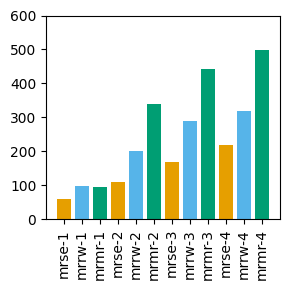

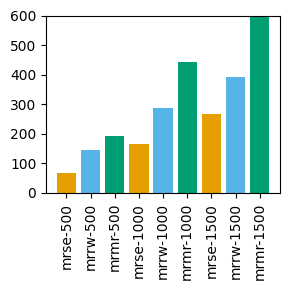

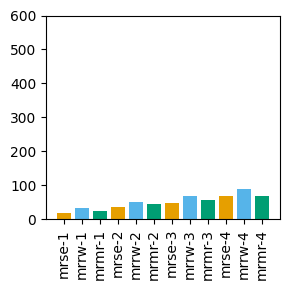

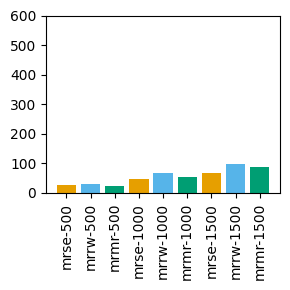

In [11]:
b1000_clustered_lookup = {
"gen-lawn-n_1-b_1000-e_mrmr-custom-clustered": "mrse-1",
"gen-rw-n_1-b_1000-e_mrmr-custom-clustered": "mrrw-1",
"gen-mrmr-n_1-b_1000-e_mrmr-custom-clustered": "mrmr-1",
"gen-lawn-n_2-b_1000-e_mrmr-custom-clustered": "mrse-2",
"gen-rw-n_2-b_1000-e_mrmr-custom-clustered": "mrrw-2",
"gen-mrmr-n_2-b_1000-e_mrmr-custom-clustered": "mrmr-2",
"gen-lawn-n_3-b_1000-e_mrmr-custom-clustered": "mrse-3",
"gen-rw-n_3-b_1000-e_mrmr-custom-clustered": "mrrw-3",
"gen-mrmr-n_3-b_1000-e_mrmr-custom-clustered": "mrmr-3",
"gen-lawn-n_4-b_1000-e_mrmr-custom-clustered": "mrse-4",
"gen-rw-n_4-b_1000-e_mrmr-custom-clustered": "mrrw-4",
"gen-mrmr-n_4-b_1000-e_mrmr-custom-clustered": "mrmr-4"
}

b1000_unclustered_lookup = {
"gen-lawn-n_1-b_1000-e_mrmr-custom-notclustered": "mrse-1",
"gen-rw-n_1-b_1000-e_mrmr-custom-notclustered": "mrrw-1",
"gen-mrmr-n_1-b_1000-e_mrmr-custom-notclustered": "mrmr-1",
"gen-lawn-n_2-b_1000-e_mrmr-custom-notclustered": "mrse-2",
"gen-rw-n_2-b_1000-e_mrmr-custom-notclustered": "mrrw-2",
"gen-mrmr-n_2-b_1000-e_mrmr-custom-notclustered": "mrmr-2",
"gen-lawn-n_3-b_1000-e_mrmr-custom-notclustered": "mrse-3",
"gen-rw-n_3-b_1000-e_mrmr-custom-notclustered": "mrrw-3",
"gen-mrmr-n_3-b_1000-e_mrmr-custom-notclustered": "mrmr-3",
"gen-lawn-n_4-b_1000-e_mrmr-custom-notclustered": "mrse-4",
"gen-rw-n_4-b_1000-e_mrmr-custom-notclustered": "mrrw-4",
"gen-mrmr-n_4-b_1000-e_mrmr-custom-notclustered": "mrmr-4"
}

n3_clustered_lookup = {
"gen-lawn-n_3-b_500-e_mrmr-custom-clustered": "mrse-500",
"gen-rw-n_3-b_500-e_mrmr-custom-clustered": "mrrw-500",
"gen-mrmr-n_3-b_500-e_mrmr-custom-clustered": "mrmr-500",
"gen-lawn-n_3-b_1000-e_mrmr-custom-clustered": "mrse-1000",
"gen-rw-n_3-b_1000-e_mrmr-custom-clustered": "mrrw-1000",
"gen-mrmr-n_3-b_1000-e_mrmr-custom-clustered": "mrmr-1000",
"gen-lawn-n_3-b_1500-e_mrmr-custom-clustered": "mrse-1500",
"gen-rw-n_3-b_1500-e_mrmr-custom-clustered": "mrrw-1500",
"gen-mrmr-n_3-b_1500-e_mrmr-custom-clustered": "mrmr-1500"
}

n3_unclustered_lookup = {
"gen-lawn-n_3-b_500-e_mrmr-custom-notclustered": "mrse-500",
"gen-rw-n_3-b_500-e_mrmr-custom-notclustered": "mrrw-500",
"gen-mrmr-n_3-b_500-e_mrmr-custom-notclustered": "mrmr-500",
"gen-lawn-n_3-b_1000-e_mrmr-custom-notclustered": "mrse-1000",
"gen-rw-n_3-b_1000-e_mrmr-custom-notclustered": "mrrw-1000",
"gen-mrmr-n_3-b_1000-e_mrmr-custom-notclustered": "mrmr-1000",
"gen-lawn-n_3-b_1500-e_mrmr-custom-notclustered": "mrse-1500",
"gen-rw-n_3-b_1500-e_mrmr-custom-notclustered": "mrrw-1500",
"gen-mrmr-n_3-b_1500-e_mrmr-custom-notclustered": "mrmr-1500"
}

comparative_detections(runs_b1000_clustered, "by_robot_count_clustered", ROBOT_COLORS[0:3], b1000_clustered_lookup)
comparative_detections(runs_n3_clustered, "by_budget_clustered", ROBOT_COLORS[0:3], n3_clustered_lookup)
comparative_detections(runs_b1000_unclustered, "by_robot_count_unclustered", ROBOT_COLORS[0:3], b1000_unclustered_lookup)
comparative_detections(runs_n3_unclustered, "by_budget_unclustered", ROBOT_COLORS[0:3], n3_unclustered_lookup)

